In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "1" 
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import time
import matplotlib as mpl
mpl.rc('text', usetex = True)
mpl.rc('font', family = 'serif')

import tensorflow as tf # implemented in TF 2.x
# tf.config.set_visible_devices([], 'GPU') #disables GPU
tf.keras.backend.set_floatx('float64')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.config.threading.set_inter_op_parallelism_threads(1) #to run on one processor
tf.config.threading.set_intra_op_parallelism_threads(1)
from tensorflow.python.ops import math_ops

# model-free ESN
%run ESN_bias.ipynb
# model to compute reservoir state derivative
%run ESN_bias_drdt.ipynb

Num GPUs Available:  0


## Data

In [2]:
## Load data obtained using scipy.odeint
hf       = h5py.File('./data/Lorenz_odeint.h5','r')
u_exact  = np.array(hf.get('q'))
t        = np.array(hf.get('t'))
hf.close()

t_lyap    = 0.906**(-1)    # Lyapunov time
dt        = t[1]-t[0]      # timestep 

## Parameters for the split of the data
begin   = 50    # begin of training set (wash out at the start to remove the transient of the reservoir)
end     = 10050 # end of training set

cut1    = 1000 # to get rid of the initial transient in the simulation (to get to the attractor)
u_exact = u_exact[cut1:cut1+end+1,:] # we keep only the necessary data

n_state    = u_exact.shape[1]  # size of the entire state
n_hidden   = 1 # size of the hidden state
n_observed = n_state - n_hidden #number of inputs to the network = size of the observed state

u_t         = u_exact[:end+1].astype("float64") # data during training

idx         = [0,2]    #indices of the input in the state vector, e.g [0,2] = [x,z]
idx1        = [0,2,1]
rnn_inputs  = u_t[:-1,idx].reshape(1, end, n_observed)  # shape needed by TF (1 is number of batches)
rnn_target  = u_t[1:,idx]

## The derivative of the inputs is needed to compute the derivative of the reservoir
def Lorenz_RHS(yy): 
    """Computes RHS of Lorenz equations"""
    # Lorenz parameters
    sigma, rho, beta = [10.0, 28.0, 8./3.]
    # Lorenz equations
    x,y,z = yy.T
    x1    = sigma*(y-x)
    y1    = rho*x - y - np.multiply(x,z)
    z1    = np.multiply(x,y) - beta*z
    return np.stack([x1,y1,z1],axis=1)

u_der = Lorenz_RHS(u_exact) #RHS of the equations, namely the system true time derivative
rnn_inputs_der = u_der[:end+1].astype("float64")[:-1,idx].reshape(1,end, n_observed) #same of inputs

## Echo State Network

In [3]:
### ESN Hyperparameters 
num_units    = 100 # neurons
decay        = 1.0 # for leaky-ESN
rho_spectral = 0.9 # spectral radius of Wecho (for reconstruction high values of the spectral radius)
sigma_in     = 0.1 # scaling of input weight (set for the inputs to be comparable with reservoir state)
connectivity = 20
sparseness   = 1. - connectivity/ (num_units - 1.) # sparseness of Wecho
# it's defined as 1 - degree / (num_units - 1) where degree is the average number of connections of a unit to other units in reservoir
lmb          = 1e-6 # Tikhonov parameter
activation   = lambda x: tf.keras.activations.tanh(x) #the activation function of the ESN
b_in         = 10   # input bias (set to have same order of magnitude of inputs)

# Generate reservoir
random_seed = 1 # seed for the random realization of input and state matrix
rng = np.random.RandomState(random_seed)
# The ESN is created as a cell for the object Recurrent Neural Network in ESN_bias.ipynb
# It provides only the states of the reservoir (so it does not contain Wout)
cell = EchoStateRNNCell(num_units=num_units, 
                        num_inputs=n_observed,
                        activation=activation, 
                        decay=decay, 
                        rho=rho_spectral, 
                        sigma_in=sigma_in, 
                        b_in = b_in, 
                        sparseness = sparseness,
                        rng=rng)

# ESN created as a RNN with custom cell from ESN_bias.ipynb
ESN            = tf.keras.layers.RNN(cell=cell,dtype=tf.float64,
                                     return_sequences=True, return_state=True)

## Model-free ESN for the Oberved State

We run the ESN without any knowledge of the physics to determine the output matrix for the observed state using ridge regression and initialize the output matrix for the hidden state using the best estimate for the mean of the hidden states.

In [4]:
def outputs(inputs, init_state, ESN):
    """ Compute the reservoir states in open-loop for a time-series of the inputs """
    outputs, last_state = ESN(inputs=inputs, initial_state=init_state)
    outputs = tf.concat([outputs, tf.ones([1,outputs.shape[1],1], dtype=tf.float64), inputs],
                        axis=2) #we concatenate a bias and the inputs to the reservoir state
    return outputs, last_state

# arbitrary intial value of the reservoir state before washout
rnn_init_state = tf.constant(np.zeros([1, num_units])) 
# rnn_inputs     = tf.constant(rnn_inputs)
stored_outputs, final_state = outputs(rnn_inputs, rnn_init_state,ESN)

stored_outputs = stored_outputs[0].numpy() #Need to convert all to 2d arrays, not done inside the outputs function due to the loop in the outputs_pred function

RR = stored_outputs[begin:end] # reservoir states without washout

# Compute the output matrix for the observed state
# We directly solve the system resulting from ridge regression
LHS   = np.dot(RR.T, RR) + lmb*np.eye(num_units+n_observed+1)
RHS   = np.dot(RR.T, rnn_target[begin:end])
Wout1 = np.linalg.solve(LHS, RHS)

# Initialize the output matrix for the hidden state
h_mean = 10 #prior knowledge on the mean of the hidden state
RHS   = np.dot(RR.T, np.ones((end-begin,1))*h_mean)
Wout2 = np.linalg.solve(LHS, RHS).reshape(num_units+n_observed+1,1)

# entire output matrix is the concatenation of the two output matrices
Y_obs = np.matmul(stored_outputs,Wout1)
Y_hid = np.matmul(stored_outputs,Wout2)

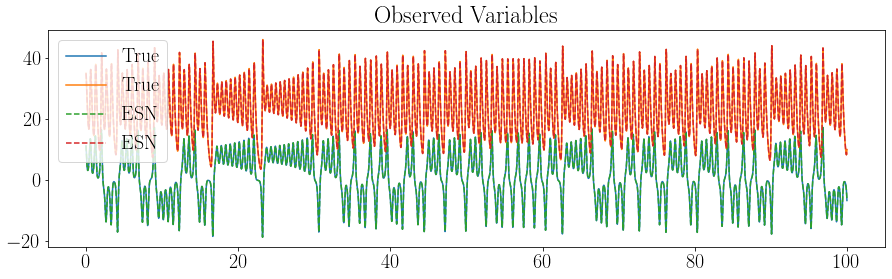

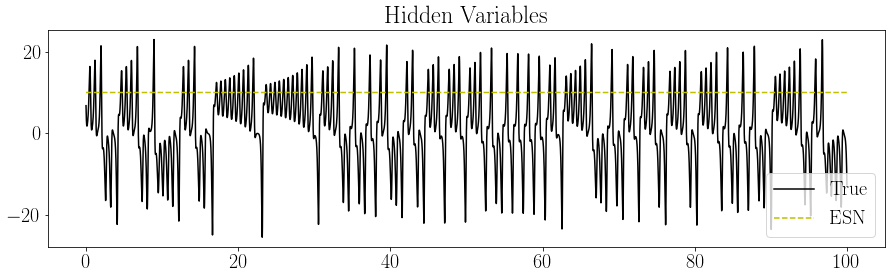

In [5]:
# Plot the prediction of observed states and hidden states after initialization
plt.rcParams["figure.figsize"] = (15,4)
plt.rcParams["font.size"] = 20

#Training set plot for the observed variables
plt.title('Observed Variables')
plt.plot(np.arange(end-begin)*dt/t_lyap,rnn_target[begin:end],label='True')
plt.plot(np.arange(end-begin)*dt/t_lyap,Y_obs[begin:end],'--', label='ESN')
plt.legend()

#Training set plot for the hidden variables
plt.figure()
plt.title('Hidden Variables')
plt.plot(np.arange(end-begin)*dt/t_lyap,u_t[1+begin:1+end,idx1[n_observed:]],'k',label='True')
plt.plot(np.arange(end-begin)*dt/t_lyap,Y_hid[begin:end],'y--', label='ESN')
plt.legend()

plt.show()

## Computing the derivative of the reservoir state with automatic differentiation

We compute the derivative of the reservoir state using the model implemented in ESN_bias_drdt.ipynb.

We define a different cell with identical hyperparameters, input and state matrix.
This cell however provides as an output an array of size 2*(num_units)
which consists in the concatenation of the reservoir state and its time derivative.
The cell works in the same way as of the ESN and computes the time derivative of the reservoir as the cell marches through the time series, so it is implemented using the RNN framework in tensorflow.

In [6]:
@tf.function
def dr_dt(inputs, init_state, ESN):
    """ Calls the model that computes the time derivative of the reservoir state
    using a TF graph """
    outputs = ESN(inputs=inputs, initial_state=init_state)[0]
    return outputs

In [7]:
%%time
cell2 = EchoStateRNNCelldrdt(num_units=num_units, 
                        num_inputs=n_observed,
                        activation=activation, 
                        decay=decay,
                        rho=rho_spectral,
                        sigma_in=sigma_in,
                        b_in = b_in,
                        sparseness = sparseness,
                        reuse = True, #to not compute new input and state matrics
                        win=cell.Win.numpy(), #use same matrices as before
                        wecho=cell.Wecho.numpy())

ESN2   = tf.keras.layers.RNN(cell=cell2,dtype=tf.float64,
                                              return_sequences=True, return_state=True)


# we need the derivative of the inputs in the model to compute the reservoir derivative
drdt_inputs    = tf.Variable(tf.concat([rnn_inputs,rnn_inputs_der],axis=2),
                        trainable=False)
#intial value of the reservoir and its derivative at beginning of washout
drdt_init_state = tf.constant(np.ones([1, 2*num_units])) 
# computing the derivative of the reservoir state
dr_dt1          = dr_dt(drdt_inputs, drdt_init_state, ESN2)

CPU times: user 21.4 s, sys: 15.6 ms, total: 21.4 s
Wall time: 21.4 s


In [8]:
# Concatenate the inputs and bias (and their derivatives) to the reservoir state (and its derivative)
r1 = tf.concat([dr_dt1[:,:,:num_units], tf.ones([1,dr_dt1.shape[1],1], dtype=tf.float64),
                    rnn_inputs[:,:,:]],axis=2)
dr_dt = tf.concat([dr_dt1[:,:,num_units:], tf.zeros([1,dr_dt1.shape[1],1], dtype=tf.float64),
                    rnn_inputs_der[:,:,:]],axis=2)

# save the reservoir state and its derivative for the nonlinear optimization
fln = './data/Lorenz_Rec_drdt_' + str(idx) + '_' + str(num_units) + '_' + str(end) + '.h5'
hf = h5py.File(fln,'w')
hf.create_dataset('drdt',data=dr_dt)
hf.create_dataset('r',data=r1)
hf.close()

#MSE for the prediction and the the derivatives of the observed state
y_pred  = np.matmul(r1[0,begin:end-1], Wout1)    #predicted observed state
y_dot   = np.matmul(dr_dt[0,begin:end-1], Wout1) #output derivative with automatic differentiation
y_eul   = (y_pred[1:] - y_pred[:-1])/dt          #output derivative with forward euler

print('MSE in the prediction of the observed state              :',
      np.mean((y_pred - rnn_inputs[0,begin+1:end])**2))
print('MSE in the time derivative with automatic differentiation:',
      np.mean((y_dot  - rnn_inputs_der[0,begin+1:end])**2))
print('MSE in the time derivative with forward Euler            :',
      np.mean((y_eul  - rnn_inputs_der[0,begin+1:end-1])**2))


MSE in the prediction of the observed state              : 3.1505129044420613e-07
MSE in the time derivative with automatic differentiation: 0.0009303133234898203
MSE in the time derivative with forward Euler            : 20.399738707593556


## Computing the output matrix for the Hidden State 

We use the governing equations and automatic differentiation to compute the output matrix for the hidden state. We do so by minimizing the error of the API-ESN output derivative with respect to the RHS of the governing equations evaluated at the output in the function phys_loss.

In [9]:
def batchez(l,r,dr,y_o,dy_o):
    """ Generates l batches from data which consist of points separated one from
    the other by  length=(size of the dataset) / (l), so that for example the first
    batch contains the timesteps [0,5,10,...], the second one [1,6,11,...], etc."""
    
    size       = end-begin
    length     = int(size)//l #separation between points
    idx_vec    = np.zeros((l, length), dtype=np.int32) #array with the indices to create the batches from dataset
    r1         = np.zeros((l, length, r.shape[2])) #reservoir states
    dr1        = np.zeros((l, length, dr.shape[2])) #reservoir states derivative
    y_o1       = np.zeros((l, length, y_o.shape[2])) #observed output
    dy_o1      = np.zeros((l, length, dy_o.shape[2])) #observed output derivative
    
    for i in range(l):
        idx_vec[i] = np.arange(size)[i::l]
        r1[i]      = r[0,-size:][idx_vec[i]]
        dr1[i]     = dr[0,-size:][idx_vec[i]]
        y_o1[i]    = y_o[0,-size:][idx_vec[i]]
        dy_o1[i]   = dy_o[0,-size:][idx_vec[i]]
    
    return r1, dr1, y_o1, dy_o1

def Lorenz_rec(yy,sigma,rho,beta): 
    """ Lorenz equations with indices following idx variable for reconstruction 
    Needs to be changed manually when changing idx as TF does not accept list for indices"""
    x,z,y = tf.unstack(yy,axis=1)
    x1    = sigma*(y-x)
    y1    = rho*x - y - tf.multiply(x,z)
    z1    = tf.multiply(x,y) - beta*z
    return tf.stack([x1,z1,y1],axis=1)

@tf.function
def phys_loss(r, dr, y_o, dy_o):
    """ Computes the loss with respect to the governing equations using automatic differentiation
        and applies gradient descent to minimize it """
    
    #hidden state output and its derivative
    y_h            = tf.matmul(r, Wout_hid) 
    dy_h           = tf.matmul(dr,Wout_hid)
    
    # concatenate the oberved state and hidden state to have the entire state
    y_Lor          = Lorenz_rec(tf.concat([y_o,y_h],axis=1), 10., 28., 8./3) #RHS of gov equations evaluated at the output
    
    #compute the loss
    loss           = Loss_Mse(tf.concat([dy_o,dy_h],axis=1),y_Lor)
    
    #compute and apply the gradients
    grad           = tf.gradients(loss, Wout_hid)    #gradient of the loss wrt the weights
    optimizer.apply_gradients(zip(grad,[Wout_hid]))  #faster to apply gradients inside the graph
    
    return loss, tf.concat([dy_o,dy_o],axis=1), y_Lor

In [10]:
# load the reservoir state and its derivative
hf   = h5py.File('./data/Lorenz_Rec_drdt_' + str(idx) + '_' + str(num_units) + '_' + str(end) + '.h5','r')
dr   = np.array(hf.get('drdt'))
r    = np.array(hf.get('r'))
hf.close()

FE            = False #to use forward eurler instead of automatic differentiation
if FE:
    dr        = (r[:,1:]-r[:,:-1])/dt #also FE is computed beforehand using the reservoir state 
    r         =  r[:,:-1]             #it allows us to use batches where the points are not subsequent one to the other
        
# output of the observed state and its derivative
y_o            = np.matmul(r,Wout1)
dy_o           = np.matmul(dr,Wout1)

# tensorflow variable to be optimized 
Wout_hid       = tf.Variable(Wout2)

Epoch 00000, Time per epoch: 0.00058
Loss 3625.27148438, True Loss: 47.76965714
Loss_change -2.748e-02, True Loss_Change: 1.000e-04
l_rate: 1.000e-01



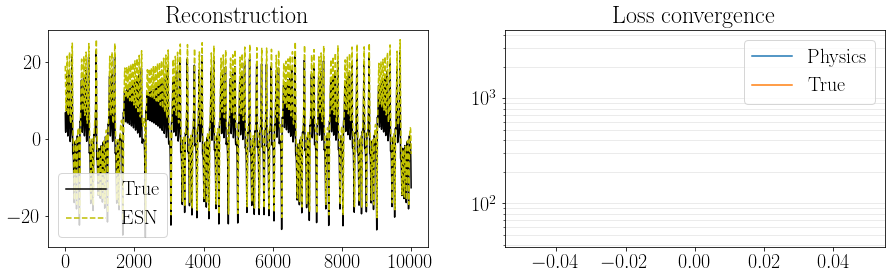

Epoch 00500, Time per epoch: 0.00489
Loss 34.38973999, True Loss: 0.16325693
Loss_change -2.908e+00, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 01000, Time per epoch: 0.00391
Loss 13.34257698, True Loss: 0.05187074
Loss_change -7.495e+00, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 01500, Time per epoch: 0.00377
Loss 7.39626265, True Loss: 0.02698525
Loss_change -1.352e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 02000, Time per epoch: 0.00384
Loss 5.52574730, True Loss: 0.03296981
Loss_change -1.810e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 02500, Time per epoch: 0.00383
Loss 4.53096104, True Loss: 0.01702669
Loss_change -2.207e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 03000, Time per epoch: 0.00360
Loss 3.48015356, True Loss: 0.01374583
Loss_change -2.873e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 03500, Time per epoch: 0.00381
Loss 10.87754440, True Loss: 0.05694265
Loss_change -9.193e+00, True Loss_Chang

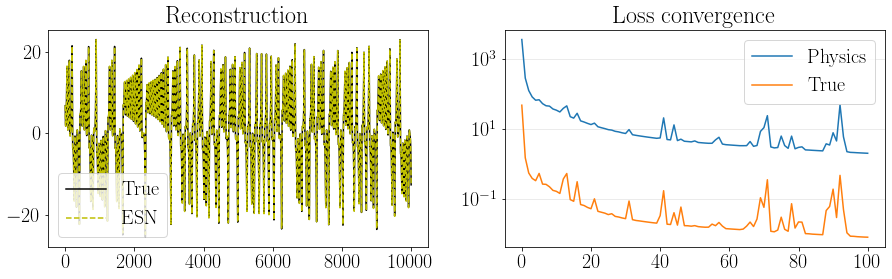

Epoch 05500, Time per epoch: 0.00420
Loss 13.82809830, True Loss: 0.03432356
Loss_change -7.232e+00, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 06000, Time per epoch: 0.00380
Loss 1.62474430, True Loss: 0.00630902
Loss_change -6.155e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 06500, Time per epoch: 0.00370
Loss 2.05883932, True Loss: 0.00817934
Loss_change -4.857e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 07000, Time per epoch: 0.00354
Loss 3.88150001, True Loss: 0.11922787
Loss_change -2.576e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 07500, Time per epoch: 0.00381
Loss 1.25211072, True Loss: 0.00477271
Loss_change -7.987e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 08000, Time per epoch: 0.00389
Loss 1.20735669, True Loss: 0.06928400
Loss_change -8.283e+01, True Loss_Change: 1.000e-04
l_rate: 1.000e-01

Epoch 08500, Time per epoch: 0.00360
Loss 1.08563840, True Loss: 0.00410438
Loss_change -9.211e+01, True Loss_Change:

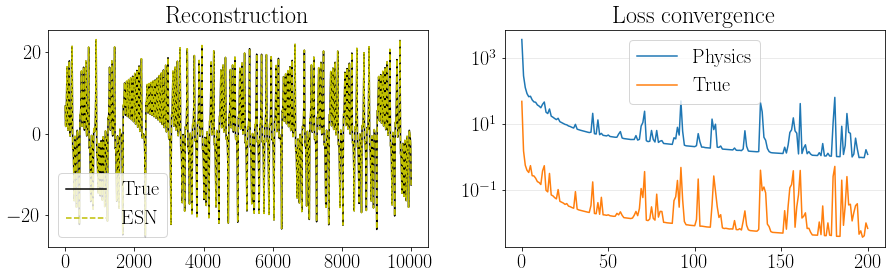

Epoch 10500, Time per epoch: 0.00422
Loss 20.71911049, True Loss: 0.22326136
Loss_change -6.598e-05, True Loss_Change: 2.688e-05
l_rate: 1.000e-01

Epoch 11000, Time per epoch: 0.00379
Loss 0.89836866, True Loss: 0.00435215
Loss_change -1.385e-03, True Loss_Change: -1.092e-03
l_rate: 1.000e-01

Epoch 11500, Time per epoch: 0.00380
Loss 0.78749561, True Loss: 0.00294547
Loss_change -8.392e-04, True Loss_Change: -8.162e-04
l_rate: 1.000e-01

Epoch 12000, Time per epoch: 0.00384
Loss 0.75740725, True Loss: 0.00284364
Loss_change -6.296e-04, True Loss_Change: -1.059e-03
l_rate: 1.000e-01

Epoch 12500, Time per epoch: 0.00375
Loss 0.72915566, True Loss: 0.00272004
Loss_change -5.214e-04, True Loss_Change: -5.260e-04
l_rate: 5.000e-02

Epoch 13000, Time per epoch: 0.00392
Loss 1.04593229, True Loss: 0.01547692
Loss_change -2.327e-04, True Loss_Change: 1.118e-05
l_rate: 5.000e-02

Epoch 13500, Time per epoch: 0.00396
Loss 0.67937249, True Loss: 0.00254046
Loss_change -1.501e-03, True Loss_Cha

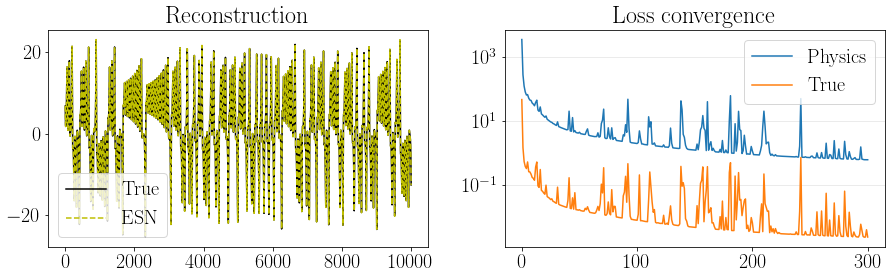

Epoch 15500, Time per epoch: 0.00436
Loss 0.60571098, True Loss: 0.00227563
Loss_change -2.183e-03, True Loss_Change: -1.408e-03
l_rate: 5.000e-02

Epoch 16000, Time per epoch: 0.00388
Loss 0.58844632, True Loss: 0.00220644
Loss_change -1.761e-04, True Loss_Change: -1.859e-04
l_rate: 5.000e-02

Epoch 16500, Time per epoch: 0.00387
Loss 0.61164606, True Loss: 0.00215734
Loss_change -2.366e-04, True Loss_Change: -2.791e-04
l_rate: 2.500e-02

Epoch 17000, Time per epoch: 0.00391
Loss 0.60608685, True Loss: 0.00227317
Loss_change -5.404e-04, True Loss_Change: -5.145e-03
l_rate: 1.250e-02

Epoch 17500, Time per epoch: 0.00388
Loss 0.94364101, True Loss: 0.00912214
Loss_change -3.269e-05, True Loss_Change: 4.768e-05
l_rate: 1.250e-02

Epoch 18000, Time per epoch: 0.00373
Loss 0.54697782, True Loss: 0.00206425
Loss_change -1.207e-04, True Loss_Change: -3.256e-03
l_rate: 1.250e-02

Epoch 18500, Time per epoch: 0.00393
Loss 0.53073347, True Loss: 0.00200697
Loss_change -1.046e-04, True Loss_Cha

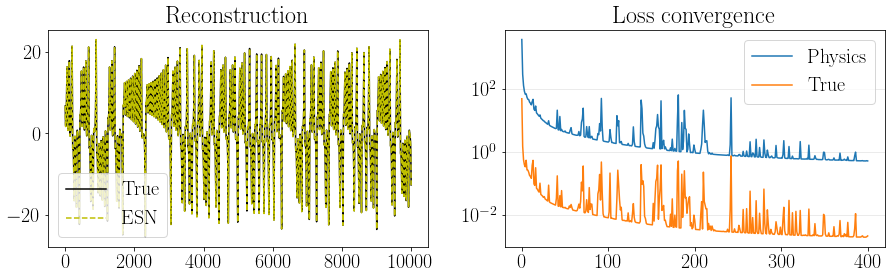

Epoch 20500, Time per epoch: 0.00423
Loss 0.49620664, True Loss: 0.00188278
Loss_change -4.076e-03, True Loss_Change: -1.176e-02
l_rate: 6.250e-03

Epoch 21000, Time per epoch: 0.00379
Loss 0.49839357, True Loss: 0.00196622
Loss_change -8.025e-05, True Loss_Change: -1.213e-04
l_rate: 6.250e-03

Epoch 21500, Time per epoch: 0.00399
Loss 0.48159108, True Loss: 0.00183212
Loss_change -6.352e-05, True Loss_Change: -6.077e-05
l_rate: 6.250e-03

Epoch 22000, Time per epoch: 0.00369
Loss 0.47487694, True Loss: 0.00180733
Loss_change -5.950e-05, True Loss_Change: -5.734e-05
l_rate: 6.250e-03

Epoch 22500, Time per epoch: 0.00392
Loss 0.46876508, True Loss: 0.00179380
Loss_change -5.555e-05, True Loss_Change: -5.164e-05
l_rate: 6.250e-03

Epoch 23000, Time per epoch: 0.00368
Loss 0.46524796, True Loss: 0.00179550
Loss_change -1.248e-04, True Loss_Change: -7.620e-04
l_rate: 6.250e-03

Epoch 23500, Time per epoch: 0.00402
Loss 0.46051660, True Loss: 0.00182197
Loss_change -4.752e-05, True Loss_Ch

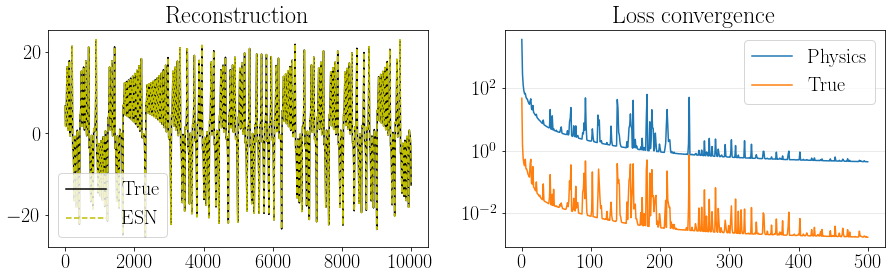

Epoch 25500, Time per epoch: 0.00430
Loss 0.43937013, True Loss: 0.00172228
Loss_change -3.786e-05, True Loss_Change: -3.213e-05
l_rate: 6.250e-03

Epoch 26000, Time per epoch: 0.00390
Loss 0.44451210, True Loss: 0.00178207
Loss_change -3.238e-05, True Loss_Change: -2.381e-05
l_rate: 6.250e-03

Epoch 26500, Time per epoch: 0.00377
Loss 0.42816910, True Loss: 0.00165619
Loss_change -4.285e-05, True Loss_Change: -3.026e-05
l_rate: 6.250e-03

Epoch 27000, Time per epoch: 0.00371
Loss 0.42352241, True Loss: 0.00162901
Loss_change -4.311e-05, True Loss_Change: -3.954e-05
l_rate: 6.250e-03

Epoch 27500, Time per epoch: 0.00395
Loss 0.41957587, True Loss: 0.00161169
Loss_change -1.249e-04, True Loss_Change: -4.660e-04
l_rate: 6.250e-03

Epoch 28000, Time per epoch: 0.00366
Loss 0.41587323, True Loss: 0.00164416
Loss_change -3.153e-05, True Loss_Change: -2.555e-05
l_rate: 6.250e-03

Epoch 28500, Time per epoch: 0.00402
Loss 0.41928712, True Loss: 0.00171733
Loss_change -2.658e-05, True Loss_Ch

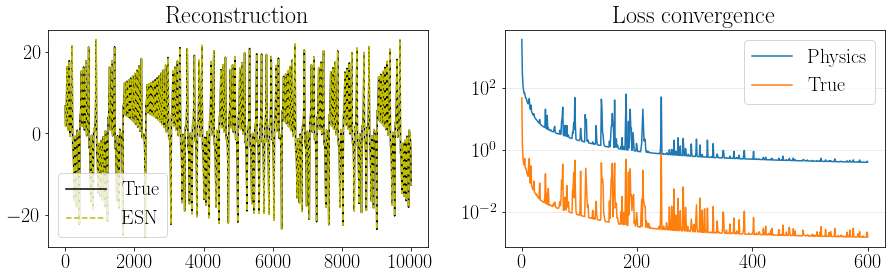

Epoch 30500, Time per epoch: 0.00442
Loss 0.39810836, True Loss: 0.00153562
Loss_change -2.464e-05, True Loss_Change: -2.261e-05
l_rate: 6.250e-03

Epoch 31000, Time per epoch: 0.00387
Loss 0.39493284, True Loss: 0.00152334
Loss_change -2.620e-05, True Loss_Change: -2.907e-05
l_rate: 6.250e-03

Epoch 31500, Time per epoch: 0.00390
Loss 0.39184335, True Loss: 0.00151072
Loss_change -2.290e-05, True Loss_Change: -2.127e-05
l_rate: 6.250e-03

Epoch 32000, Time per epoch: 0.00380
Loss 0.38907519, True Loss: 0.00150037
Loss_change -2.205e-05, True Loss_Change: -2.046e-05
l_rate: 3.125e-03

Epoch 32500, Time per epoch: 0.00412
Loss 0.39333570, True Loss: 0.00157336
Loss_change -1.918e-05, True Loss_Change: -1.401e-05
l_rate: 3.125e-03

Epoch 33000, Time per epoch: 0.00387
Loss 0.38329488, True Loss: 0.00147910
Loss_change -2.138e-05, True Loss_Change: -2.139e-05
l_rate: 3.125e-03

Epoch 33500, Time per epoch: 0.00370
Loss 0.38078314, True Loss: 0.00147069
Loss_change -2.094e-05, True Loss_Ch

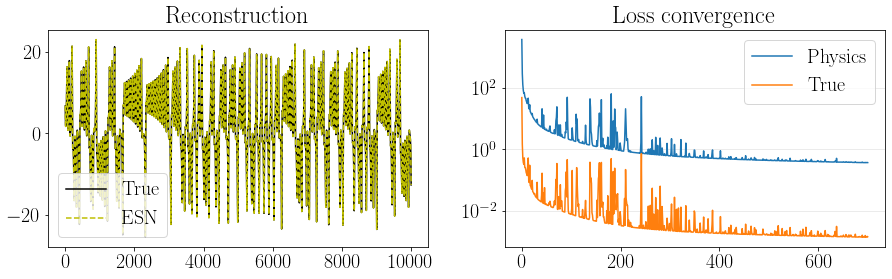

Epoch 35500, Time per epoch: 0.00416
Loss 0.37085688, True Loss: 0.00144352
Loss_change -1.847e-05, True Loss_Change: -1.931e-05
l_rate: 3.125e-03

Epoch 36000, Time per epoch: 0.00394
Loss 0.36763126, True Loss: 0.00141823
Loss_change -2.091e-05, True Loss_Change: -2.565e-05
l_rate: 3.125e-03

Epoch 36500, Time per epoch: 0.00390
Loss 0.36507785, True Loss: 0.00141078
Loss_change -1.728e-05, True Loss_Change: -1.739e-05
l_rate: 3.125e-03

Epoch 37000, Time per epoch: 0.00394
Loss 0.37081850, True Loss: 0.00144055
Loss_change -1.421e-05, True Loss_Change: -1.308e-05
l_rate: 3.125e-03

Epoch 37500, Time per epoch: 0.00395
Loss 0.36946288, True Loss: 0.00155893
Loss_change -1.356e-05, True Loss_Change: -3.385e-06
l_rate: 3.125e-03

Epoch 38000, Time per epoch: 0.00393
Loss 0.35834277, True Loss: 0.00138687
Loss_change -1.605e-05, True Loss_Change: -1.855e-05
l_rate: 3.125e-03

Epoch 38500, Time per epoch: 0.00384
Loss 0.35830984, True Loss: 0.00147206
Loss_change -1.702e-05, True Loss_Ch

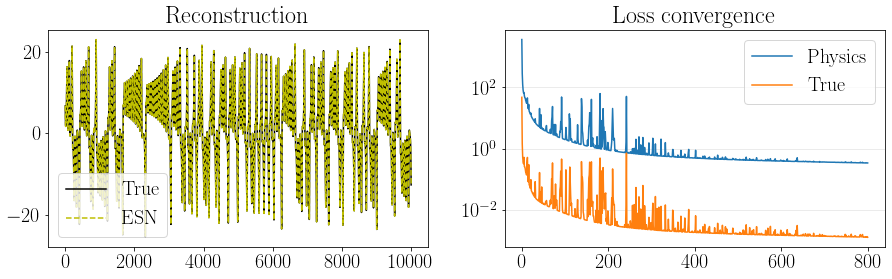

Epoch 40500, Time per epoch: 0.00472
Loss 0.34681794, True Loss: 0.00133250
Loss_change -1.479e-05, True Loss_Change: -1.524e-05
l_rate: 3.125e-03

Epoch 41000, Time per epoch: 0.00447
Loss 0.35062394, True Loss: 0.00143315
Loss_change -1.264e-05, True Loss_Change: -6.293e-06
l_rate: 3.125e-03

Epoch 41500, Time per epoch: 0.00410
Loss 0.34266850, True Loss: 0.00131549
Loss_change -1.435e-05, True Loss_Change: -1.484e-05
l_rate: 3.125e-03

Epoch 42000, Time per epoch: 0.00425
Loss 0.34064668, True Loss: 0.00130715
Loss_change -1.422e-05, True Loss_Change: -1.478e-05
l_rate: 3.125e-03

Epoch 42500, Time per epoch: 0.00421
Loss 0.33851829, True Loss: 0.00129928
Loss_change -1.619e-05, True Loss_Change: -2.109e-05
l_rate: 3.125e-03

Epoch 43000, Time per epoch: 0.00450
Loss 0.33670151, True Loss: 0.00129252
Loss_change -1.384e-05, True Loss_Change: -1.444e-05
l_rate: 3.125e-03

Epoch 43500, Time per epoch: 0.00462
Loss 0.33490252, True Loss: 0.00128587
Loss_change -1.370e-05, True Loss_Ch

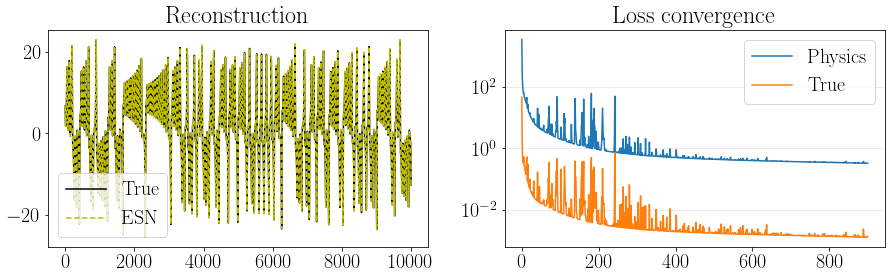

Epoch 45500, Time per epoch: 0.00522
Loss 0.33799878, True Loss: 0.00131904
Loss_change -9.721e-06, True Loss_Change: -9.437e-06
l_rate: 3.125e-03

Epoch 46000, Time per epoch: 0.00460
Loss 0.32651916, True Loss: 0.00125416
Loss_change -1.259e-05, True Loss_Change: -1.308e-05
l_rate: 3.125e-03

Epoch 46500, Time per epoch: 0.00453
Loss 0.32343867, True Loss: 0.00123579
Loss_change -1.287e-05, True Loss_Change: -1.416e-05
l_rate: 3.125e-03

Epoch 47000, Time per epoch: 0.00478
Loss 0.32290170, True Loss: 0.00123247
Loss_change -1.484e-05, True Loss_Change: -1.688e-05
l_rate: 3.125e-03

Epoch 47500, Time per epoch: 0.00448
Loss 0.32004946, True Loss: 0.00122820
Loss_change -1.544e-05, True Loss_Change: -2.693e-05
l_rate: 3.125e-03

Epoch 48000, Time per epoch: 0.00476
Loss 0.32289097, True Loss: 0.00130503
Loss_change -1.098e-05, True Loss_Change: -6.271e-06
l_rate: 3.125e-03

Epoch 48500, Time per epoch: 0.00457
Loss 0.31727543, True Loss: 0.00122494
Loss_change -1.293e-05, True Loss_Ch

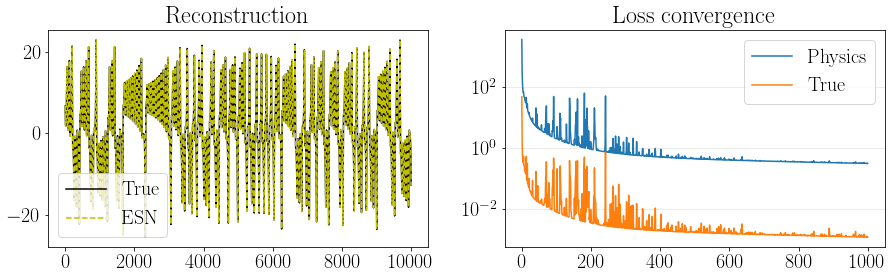

Epoch 50500, Time per epoch: 0.00426
Loss 0.31017095, True Loss: 0.00118162
Loss_change -1.182e-05, True Loss_Change: -1.277e-05
l_rate: 3.125e-03

Epoch 51000, Time per epoch: 0.00399
Loss 0.32541090, True Loss: 0.00138743
Loss_change -7.748e-06, True Loss_Change: -3.295e-06
l_rate: 3.125e-03

Epoch 51500, Time per epoch: 0.00397
Loss 0.30648351, True Loss: 0.00116104
Loss_change -1.181e-05, True Loss_Change: -1.330e-05
l_rate: 3.125e-03

Epoch 52000, Time per epoch: 0.00440
Loss 0.31206417, True Loss: 0.00125363
Loss_change -9.159e-06, True Loss_Change: -4.270e-06
l_rate: 3.125e-03

Epoch 52500, Time per epoch: 0.00442
Loss 0.30615330, True Loss: 0.00116188
Loss_change -1.057e-05, True Loss_Change: -1.183e-05
l_rate: 3.125e-03

Epoch 53000, Time per epoch: 0.00475
Loss 0.30177897, True Loss: 0.00113970
Loss_change -1.157e-05, True Loss_Change: -1.341e-05
l_rate: 3.125e-03

Epoch 53500, Time per epoch: 0.00485
Loss 0.30023748, True Loss: 0.00113318
Loss_change -1.155e-05, True Loss_Ch

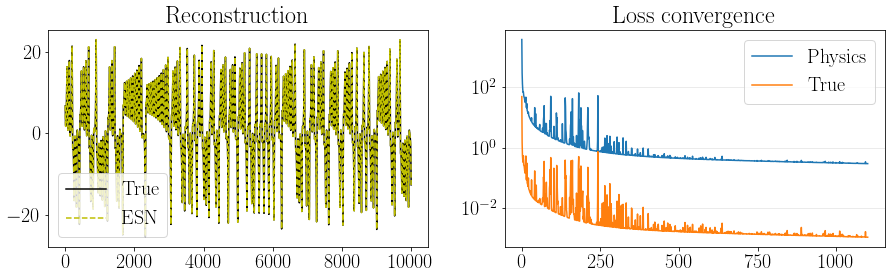

Epoch 55500, Time per epoch: 0.00451
Loss 0.29446790, True Loss: 0.00110822
Loss_change -1.478e-05, True Loss_Change: -1.902e-05
l_rate: 1.563e-03

Epoch 56000, Time per epoch: 0.00430
Loss 0.29357812, True Loss: 0.00111358
Loss_change -1.122e-05, True Loss_Change: -1.262e-05
l_rate: 1.563e-03

Epoch 56500, Time per epoch: 0.00421
Loss 0.29166007, True Loss: 0.00109801
Loss_change -1.090e-05, True Loss_Change: -1.255e-05
l_rate: 1.563e-03

Epoch 57000, Time per epoch: 0.00482
Loss 0.29031709, True Loss: 0.00109056
Loss_change -1.122e-05, True Loss_Change: -1.301e-05
l_rate: 1.563e-03

Epoch 57500, Time per epoch: 0.00464
Loss 0.28906575, True Loss: 0.00108680
Loss_change -1.072e-05, True Loss_Change: -1.301e-05
l_rate: 1.563e-03

Epoch 58000, Time per epoch: 0.00396
Loss 0.28763595, True Loss: 0.00108066
Loss_change -1.226e-05, True Loss_Change: -2.076e-05
l_rate: 1.563e-03

Epoch 58500, Time per epoch: 0.00384
Loss 0.28594032, True Loss: 0.00106997
Loss_change -1.096e-05, True Loss_Ch

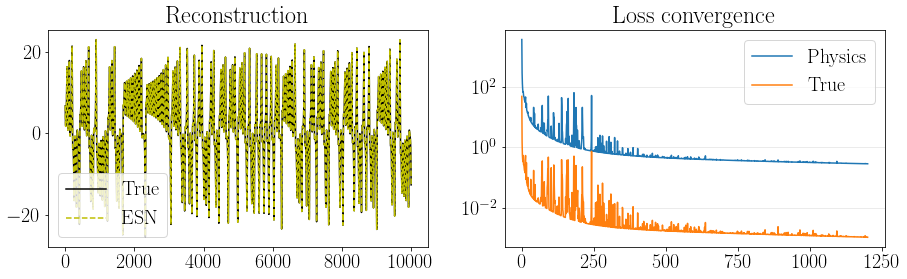

Epoch 60500, Time per epoch: 0.00480
Loss 0.28044340, True Loss: 0.00104564
Loss_change -1.060e-05, True Loss_Change: -1.300e-05
l_rate: 1.563e-03

Epoch 61000, Time per epoch: 0.00459
Loss 0.27912030, True Loss: 0.00103989
Loss_change -1.658e-05, True Loss_Change: -3.342e-05
l_rate: 1.563e-03

Epoch 61500, Time per epoch: 0.00468
Loss 0.27784991, True Loss: 0.00103313
Loss_change -1.031e-05, True Loss_Change: -1.238e-05
l_rate: 1.563e-03

Epoch 62000, Time per epoch: 0.00387
Loss 0.28025311, True Loss: 0.00107976
Loss_change -1.135e-05, True Loss_Change: -1.610e-05
l_rate: 1.563e-03

Epoch 62500, Time per epoch: 0.00399
Loss 0.27528512, True Loss: 0.00102236
Loss_change -1.121e-05, True Loss_Change: -1.365e-05
l_rate: 1.563e-03

Epoch 63000, Time per epoch: 0.00380
Loss 0.27422753, True Loss: 0.00102076
Loss_change -1.005e-05, True Loss_Change: -1.165e-05
l_rate: 1.563e-03

Epoch 63500, Time per epoch: 0.00382
Loss 0.27268118, True Loss: 0.00101066
Loss_change -1.011e-05, True Loss_Ch

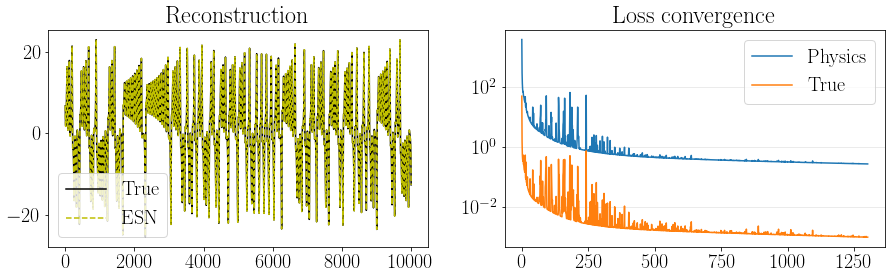

Epoch 65500, Time per epoch: 0.00426
Loss 0.27004361, True Loss: 0.00102743
Loss_change -9.045e-06, True Loss_Change: -7.864e-06
l_rate: 1.563e-03

Epoch 66000, Time per epoch: 0.00392
Loss 0.26654887, True Loss: 0.00098319
Loss_change -1.014e-05, True Loss_Change: -1.326e-05
l_rate: 1.563e-03

Epoch 66500, Time per epoch: 0.00401
Loss 0.26550260, True Loss: 0.00097843
Loss_change -9.852e-06, True Loss_Change: -1.222e-05
l_rate: 1.563e-03

Epoch 67000, Time per epoch: 0.00395
Loss 0.26454088, True Loss: 0.00097634
Loss_change -9.744e-06, True Loss_Change: -1.170e-05
l_rate: 1.563e-03

Epoch 67500, Time per epoch: 0.00378
Loss 0.26448917, True Loss: 0.00099221
Loss_change -9.292e-06, True Loss_Change: -9.534e-06
l_rate: 1.563e-03

Epoch 68000, Time per epoch: 0.00396
Loss 0.26178470, True Loss: 0.00096193
Loss_change -9.875e-06, True Loss_Change: -1.234e-05
l_rate: 1.563e-03

Epoch 68500, Time per epoch: 0.00393
Loss 0.26062301, True Loss: 0.00095696
Loss_change -9.714e-06, True Loss_Ch

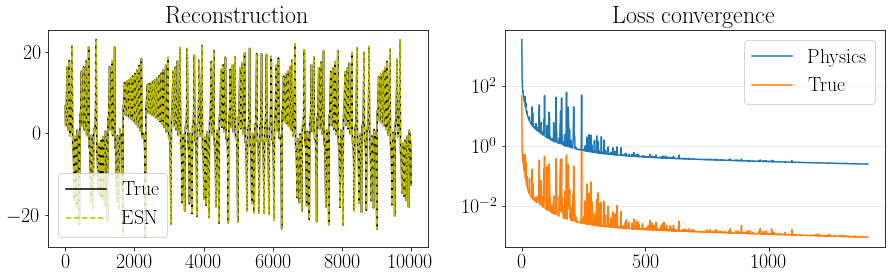

Epoch 70500, Time per epoch: 0.00438
Loss 0.25665480, True Loss: 0.00094065
Loss_change -9.269e-06, True Loss_Change: -1.116e-05
l_rate: 1.563e-03

Epoch 71000, Time per epoch: 0.00377
Loss 0.25497603, True Loss: 0.00093153
Loss_change -9.469e-06, True Loss_Change: -1.163e-05
l_rate: 1.563e-03

Epoch 71500, Time per epoch: 0.00380
Loss 0.25424895, True Loss: 0.00093299
Loss_change -9.283e-06, True Loss_Change: -1.073e-05
l_rate: 1.563e-03

Epoch 72000, Time per epoch: 0.00381
Loss 0.25689381, True Loss: 0.00095890
Loss_change -9.093e-06, True Loss_Change: -1.260e-05
l_rate: 1.563e-03

Epoch 72500, Time per epoch: 0.00392
Loss 0.25422326, True Loss: 0.00095431
Loss_change -8.285e-06, True Loss_Change: -7.131e-06
l_rate: 1.563e-03

Epoch 73000, Time per epoch: 0.00374
Loss 0.25082535, True Loss: 0.00091620
Loss_change -9.330e-06, True Loss_Change: -1.141e-05
l_rate: 1.563e-03

Epoch 73500, Time per epoch: 0.00369
Loss 0.25168124, True Loss: 0.00094065
Loss_change -8.344e-06, True Loss_Ch

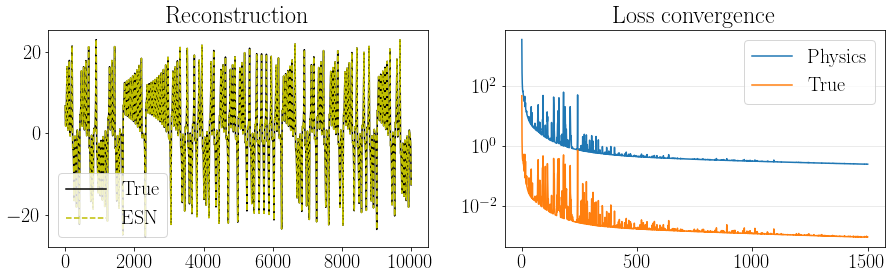

Epoch 75500, Time per epoch: 0.00416
Loss 0.24627514, True Loss: 0.00090489
Loss_change -9.651e-06, True Loss_Change: -1.354e-05
l_rate: 1.563e-03

Epoch 76000, Time per epoch: 0.00375
Loss 0.24467912, True Loss: 0.00089096
Loss_change -8.938e-06, True Loss_Change: -1.035e-05
l_rate: 1.563e-03

Epoch 76500, Time per epoch: 0.00399
Loss 0.24347842, True Loss: 0.00088100
Loss_change -9.046e-06, True Loss_Change: -1.106e-05
l_rate: 1.563e-03

Epoch 77000, Time per epoch: 0.00400
Loss 0.24344929, True Loss: 0.00088982
Loss_change -8.664e-06, True Loss_Change: -9.723e-06
l_rate: 1.563e-03

Epoch 77500, Time per epoch: 0.00373
Loss 0.24144563, True Loss: 0.00087878
Loss_change -9.544e-06, True Loss_Change: -1.291e-05
l_rate: 1.563e-03

Epoch 78000, Time per epoch: 0.00399
Loss 0.24097629, True Loss: 0.00088503
Loss_change -8.635e-06, True Loss_Change: -8.689e-06
l_rate: 1.563e-03

Epoch 78500, Time per epoch: 0.00391
Loss 0.23957106, True Loss: 0.00086574
Loss_change -8.787e-06, True Loss_Ch

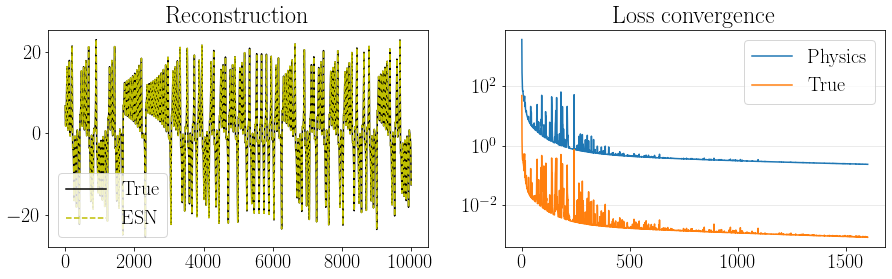

Epoch 80500, Time per epoch: 0.00421
Loss 0.23753406, True Loss: 0.00088039
Loss_change -8.050e-06, True Loss_Change: -6.844e-06
l_rate: 1.563e-03

Epoch 81000, Time per epoch: 0.00419
Loss 0.23566799, True Loss: 0.00087224
Loss_change -8.193e-06, True Loss_Change: -6.797e-06
l_rate: 1.563e-03

Epoch 81500, Time per epoch: 0.00409
Loss 0.23367859, True Loss: 0.00083726
Loss_change -8.803e-06, True Loss_Change: -1.143e-05
l_rate: 1.563e-03

Epoch 82000, Time per epoch: 0.00403
Loss 0.23275764, True Loss: 0.00083269
Loss_change -1.037e-05, True Loss_Change: -1.516e-05
l_rate: 1.563e-03

Epoch 82500, Time per epoch: 0.00393
Loss 0.23454499, True Loss: 0.00087670
Loss_change -8.390e-06, True Loss_Change: -8.852e-06
l_rate: 1.563e-03

Epoch 83000, Time per epoch: 0.00413
Loss 0.23093267, True Loss: 0.00082542
Loss_change -8.614e-06, True Loss_Change: -1.100e-05
l_rate: 1.563e-03

Epoch 83500, Time per epoch: 0.00401
Loss 0.23447481, True Loss: 0.00089229
Loss_change -7.338e-06, True Loss_Ch

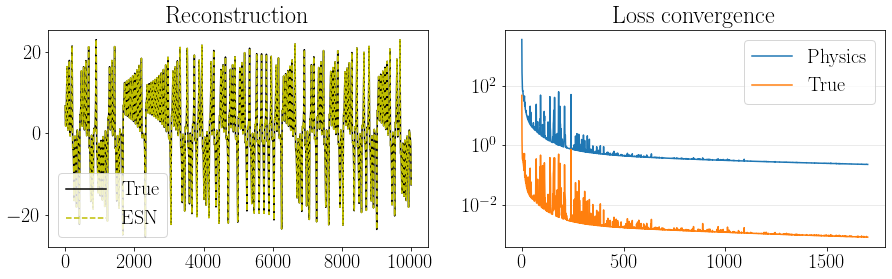

Epoch 85500, Time per epoch: 0.00422
Loss 0.22693352, True Loss: 0.00080921
Loss_change -8.523e-06, True Loss_Change: -1.182e-05
l_rate: 1.563e-03

Epoch 86000, Time per epoch: 0.00391
Loss 0.22890498, True Loss: 0.00085989
Loss_change -6.891e-06, True Loss_Change: -3.614e-06
l_rate: 1.563e-03

Epoch 86500, Time per epoch: 0.00371
Loss 0.22472270, True Loss: 0.00079733
Loss_change -8.346e-06, True Loss_Change: -1.049e-05
l_rate: 1.563e-03

Epoch 87000, Time per epoch: 0.00412
Loss 0.22395159, True Loss: 0.00079692
Loss_change -8.706e-06, True Loss_Change: -1.166e-05
l_rate: 1.563e-03

Epoch 87500, Time per epoch: 0.00391
Loss 0.22644189, True Loss: 0.00085028
Loss_change -6.626e-06, True Loss_Change: -3.352e-06
l_rate: 1.563e-03

Epoch 88000, Time per epoch: 0.00396
Loss 0.22217864, True Loss: 0.00078606
Loss_change -8.461e-06, True Loss_Change: -1.259e-05
l_rate: 1.563e-03

Epoch 88500, Time per epoch: 0.00394
Loss 0.22132945, True Loss: 0.00078217
Loss_change -8.242e-06, True Loss_Ch

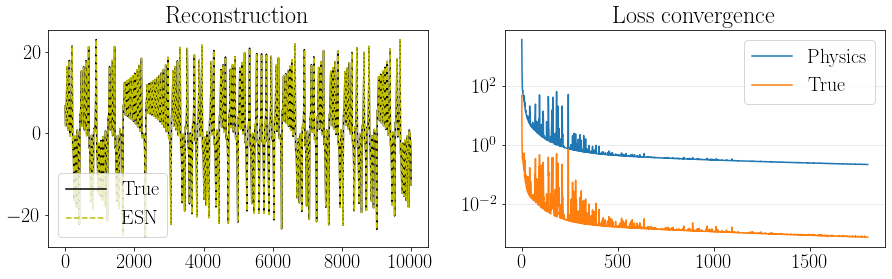

Epoch 90500, Time per epoch: 0.00409
Loss 0.21811740, True Loss: 0.00076864
Loss_change -8.902e-06, True Loss_Change: -1.454e-05
l_rate: 1.563e-03

Epoch 91000, Time per epoch: 0.00380
Loss 0.21758570, True Loss: 0.00076422
Loss_change -8.310e-06, True Loss_Change: -1.413e-05
l_rate: 1.563e-03

Epoch 91500, Time per epoch: 0.00379
Loss 0.21643330, True Loss: 0.00076102
Loss_change -7.968e-06, True Loss_Change: -1.002e-05
l_rate: 1.563e-03

Epoch 92000, Time per epoch: 0.00393
Loss 0.21563426, True Loss: 0.00075859
Loss_change -7.941e-06, True Loss_Change: -9.768e-06
l_rate: 1.563e-03

Epoch 92500, Time per epoch: 0.00368
Loss 0.21488956, True Loss: 0.00075521
Loss_change -9.147e-06, True Loss_Change: -1.609e-05
l_rate: 1.563e-03

Epoch 93000, Time per epoch: 0.00379
Loss 0.21433891, True Loss: 0.00075449
Loss_change -7.742e-06, True Loss_Change: -9.401e-06
l_rate: 1.563e-03

Epoch 93500, Time per epoch: 0.00378
Loss 0.21334349, True Loss: 0.00074788
Loss_change -9.905e-06, True Loss_Ch

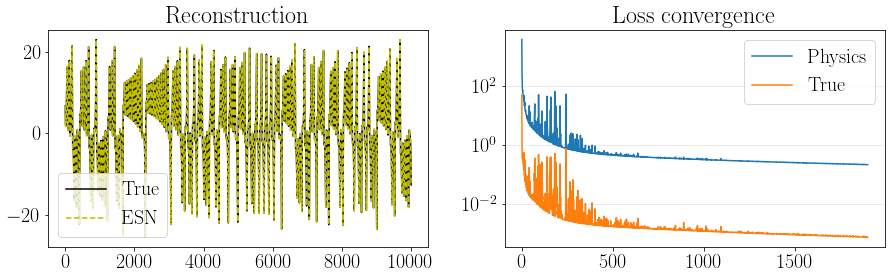

Epoch 95500, Time per epoch: 0.00403
Loss 0.21111475, True Loss: 0.00075008
Loss_change -7.493e-06, True Loss_Change: -7.884e-06
l_rate: 1.563e-03

Epoch 96000, Time per epoch: 0.00376
Loss 0.21042441, True Loss: 0.00074934
Loss_change -8.783e-06, True Loss_Change: -1.475e-05
l_rate: 1.563e-03

Epoch 96500, Time per epoch: 0.00373
Loss 0.20916978, True Loss: 0.00073384
Loss_change -7.436e-06, True Loss_Change: -8.652e-06
l_rate: 1.563e-03

Epoch 97000, Time per epoch: 0.00381
Loss 0.20954417, True Loss: 0.00075222
Loss_change -6.876e-06, True Loss_Change: -5.943e-06
l_rate: 1.563e-03

Epoch 97500, Time per epoch: 0.00370
Loss 0.20968132, True Loss: 0.00074385
Loss_change -7.993e-06, True Loss_Change: -1.431e-05
l_rate: 1.563e-03

Epoch 98000, Time per epoch: 0.00372
Loss 0.20874000, True Loss: 0.00075573
Loss_change -6.438e-06, True Loss_Change: -4.013e-06
l_rate: 1.563e-03

Epoch 98500, Time per epoch: 0.00397
Loss 0.20583399, True Loss: 0.00071485
Loss_change -7.528e-06, True Loss_Ch

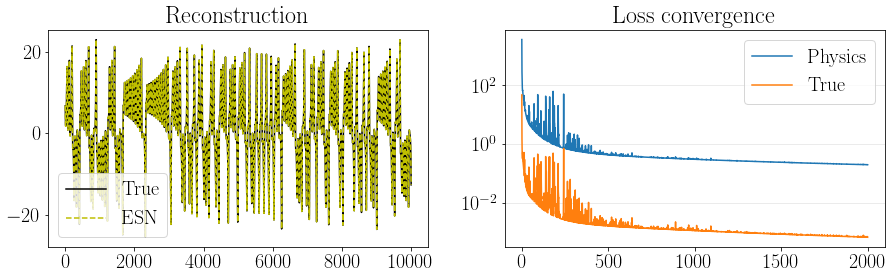

Epoch 100500, Time per epoch: 0.00435
Loss 0.20297089, True Loss: 0.00070320
Loss_change -7.462e-06, True Loss_Change: -9.306e-06
l_rate: 1.563e-03

Epoch 101000, Time per epoch: 0.00370
Loss 0.20265619, True Loss: 0.00070467
Loss_change -7.367e-06, True Loss_Change: -8.451e-06
l_rate: 1.563e-03

Epoch 101500, Time per epoch: 0.00392
Loss 0.20193301, True Loss: 0.00070518
Loss_change -7.181e-06, True Loss_Change: -7.918e-06
l_rate: 1.563e-03

Epoch 102000, Time per epoch: 0.00394
Loss 0.20095041, True Loss: 0.00069496
Loss_change -7.307e-06, True Loss_Change: -9.156e-06
l_rate: 1.563e-03

Epoch 102500, Time per epoch: 0.00394
Loss 0.20024616, True Loss: 0.00069117
Loss_change -7.313e-06, True Loss_Change: -9.266e-06
l_rate: 1.563e-03

Epoch 103000, Time per epoch: 0.00387
Loss 0.20004290, True Loss: 0.00070024
Loss_change -7.146e-06, True Loss_Change: -7.747e-06
l_rate: 1.563e-03

Epoch 103500, Time per epoch: 0.00399
Loss 0.19925135, True Loss: 0.00069024
Loss_change -7.073e-06, True 

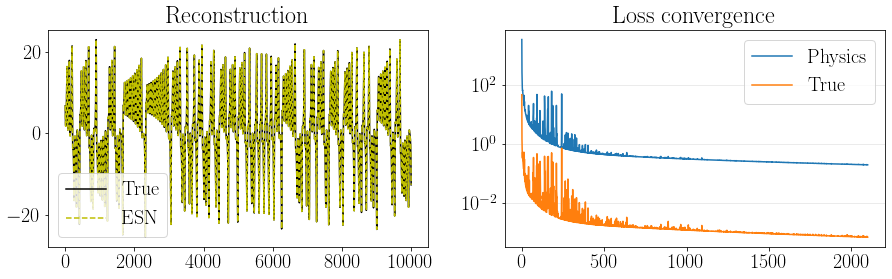

Epoch 105500, Time per epoch: 0.00434
Loss 0.19629548, True Loss: 0.00067366
Loss_change -7.549e-06, True Loss_Change: -1.134e-05
l_rate: 1.563e-03

Epoch 106000, Time per epoch: 0.00377
Loss 0.19554931, True Loss: 0.00067084
Loss_change -7.607e-06, True Loss_Change: -1.170e-05
l_rate: 1.563e-03

Epoch 106500, Time per epoch: 0.00393
Loss 0.19505341, True Loss: 0.00067418
Loss_change -7.237e-06, True Loss_Change: -8.849e-06
l_rate: 1.563e-03

Epoch 107000, Time per epoch: 0.00395
Loss 0.19555911, True Loss: 0.00068354
Loss_change -7.151e-06, True Loss_Change: -1.005e-05
l_rate: 1.563e-03

Epoch 107500, Time per epoch: 0.00405
Loss 0.19705860, True Loss: 0.00070398
Loss_change -6.406e-06, True Loss_Change: -5.664e-06
l_rate: 1.563e-03

Epoch 108000, Time per epoch: 0.00378
Loss 0.19430532, True Loss: 0.00067632
Loss_change -7.429e-06, True Loss_Change: -1.174e-05
l_rate: 1.563e-03

Epoch 108500, Time per epoch: 0.00362
Loss 0.19236881, True Loss: 0.00065779
Loss_change -7.000e-06, True 

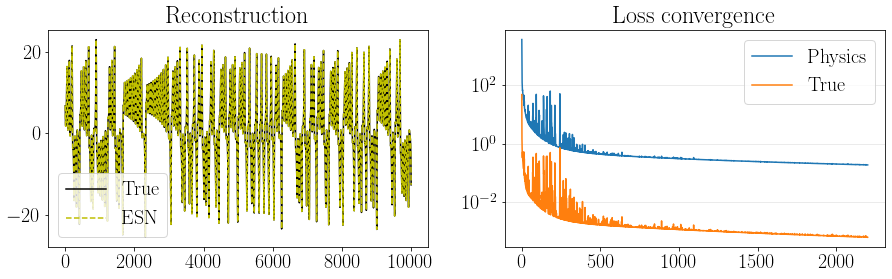

Epoch 110500, Time per epoch: 0.00432
Loss 0.19161353, True Loss: 0.00067894
Loss_change -5.927e-06, True Loss_Change: -3.573e-06
l_rate: 1.563e-03

Epoch 111000, Time per epoch: 0.00390
Loss 0.18929024, True Loss: 0.00064424
Loss_change -7.061e-06, True Loss_Change: -9.380e-06
l_rate: 1.563e-03

Epoch 111500, Time per epoch: 0.00386
Loss 0.18907355, True Loss: 0.00064582
Loss_change -6.801e-06, True Loss_Change: -9.192e-06
l_rate: 1.563e-03

Epoch 112000, Time per epoch: 0.00371
Loss 0.18814385, True Loss: 0.00063992
Loss_change -6.807e-06, True Loss_Change: -8.601e-06
l_rate: 1.563e-03

Epoch 112500, Time per epoch: 0.00379
Loss 0.18750538, True Loss: 0.00063671
Loss_change -6.795e-06, True Loss_Change: -8.553e-06
l_rate: 1.563e-03

Epoch 113000, Time per epoch: 0.00395
Loss 0.18689947, True Loss: 0.00063528
Loss_change -7.032e-06, True Loss_Change: -1.023e-05
l_rate: 1.563e-03

Epoch 113500, Time per epoch: 0.00379
Loss 0.18654542, True Loss: 0.00063383
Loss_change -6.811e-06, True 

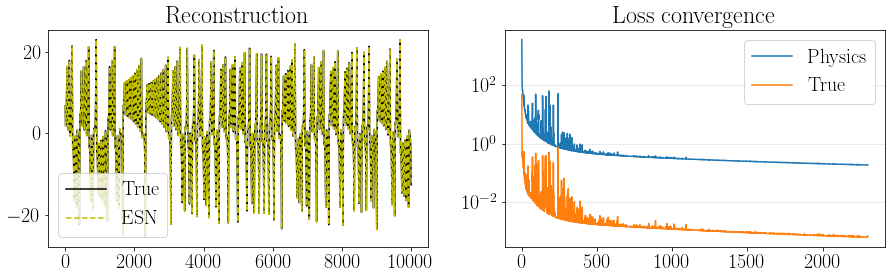

Epoch 115500, Time per epoch: 0.00418
Loss 0.18399763, True Loss: 0.00062205
Loss_change -6.684e-06, True Loss_Change: -8.297e-06
l_rate: 1.563e-03

Epoch 116000, Time per epoch: 0.00377
Loss 0.18344197, True Loss: 0.00062073
Loss_change -6.600e-06, True Loss_Change: -8.073e-06
l_rate: 1.563e-03

Epoch 116500, Time per epoch: 0.00375
Loss 0.18340835, True Loss: 0.00062377
Loss_change -6.349e-06, True Loss_Change: -8.082e-06
l_rate: 1.563e-03

Epoch 117000, Time per epoch: 0.00365
Loss 0.18258588, True Loss: 0.00062906
Loss_change -7.105e-06, True Loss_Change: -8.662e-06
l_rate: 1.563e-03

Epoch 117500, Time per epoch: 0.00372
Loss 0.18204616, True Loss: 0.00062170
Loss_change -8.247e-06, True Loss_Change: -1.323e-05
l_rate: 1.563e-03

Epoch 118000, Time per epoch: 0.00374
Loss 0.18139446, True Loss: 0.00061195
Loss_change -7.118e-06, True Loss_Change: -1.052e-05
l_rate: 1.563e-03

Epoch 118500, Time per epoch: 0.00365
Loss 0.18066271, True Loss: 0.00060837
Loss_change -6.480e-06, True 

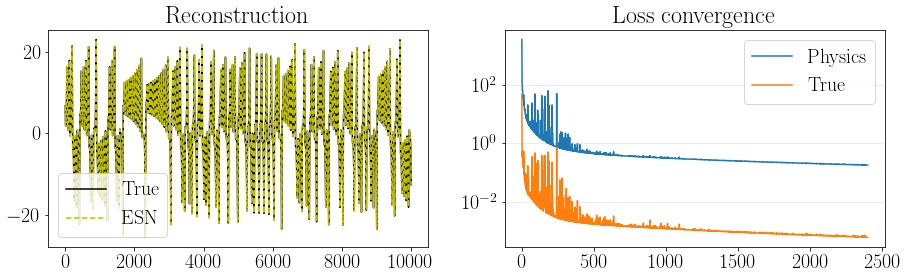

Epoch 120500, Time per epoch: 0.00404
Loss 0.17879273, True Loss: 0.00060097
Loss_change -7.171e-06, True Loss_Change: -1.298e-05
l_rate: 1.563e-03

Epoch 121000, Time per epoch: 0.00378
Loss 0.17810488, True Loss: 0.00059895
Loss_change -6.280e-06, True Loss_Change: -7.561e-06
l_rate: 1.563e-03

Epoch 121500, Time per epoch: 0.00352
Loss 0.17783681, True Loss: 0.00060152
Loss_change -6.319e-06, True Loss_Change: -7.366e-06
l_rate: 1.563e-03

Epoch 122000, Time per epoch: 0.00377
Loss 0.17792466, True Loss: 0.00060054
Loss_change -5.744e-06, True Loss_Change: -6.558e-06
l_rate: 1.563e-03

Epoch 122500, Time per epoch: 0.00397
Loss 0.17645331, True Loss: 0.00059619
Loss_change -6.263e-06, True Loss_Change: -6.795e-06
l_rate: 1.563e-03

Epoch 123000, Time per epoch: 0.00392
Loss 0.17604998, True Loss: 0.00059129
Loss_change -6.163e-06, True Loss_Change: -7.440e-06
l_rate: 1.563e-03

Epoch 123500, Time per epoch: 0.00400
Loss 0.17562968, True Loss: 0.00059431
Loss_change -6.215e-06, True 

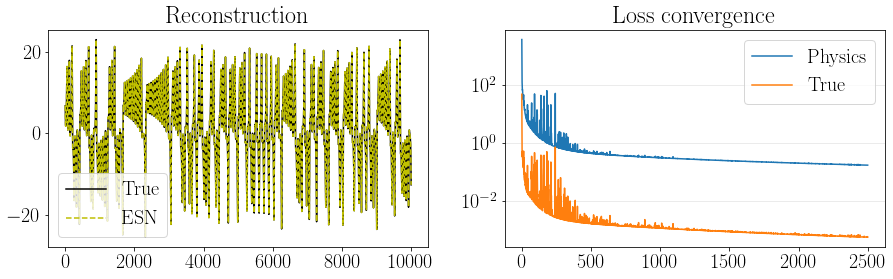

Epoch 125500, Time per epoch: 0.00420
Loss 0.17339639, True Loss: 0.00057832
Loss_change -6.114e-06, True Loss_Change: -7.562e-06
l_rate: 1.563e-03

Epoch 126000, Time per epoch: 0.00383
Loss 0.17277938, True Loss: 0.00057560
Loss_change -6.171e-06, True Loss_Change: -7.841e-06
l_rate: 1.563e-03

Epoch 126500, Time per epoch: 0.00371
Loss 0.17229006, True Loss: 0.00057344
Loss_change -6.453e-06, True Loss_Change: -8.777e-06
l_rate: 1.563e-03

Epoch 127000, Time per epoch: 0.00359
Loss 0.17183629, True Loss: 0.00057213
Loss_change -6.256e-06, True Loss_Change: -9.949e-06
l_rate: 1.563e-03

Epoch 127500, Time per epoch: 0.00381
Loss 0.17166655, True Loss: 0.00057512
Loss_change -6.046e-06, True Loss_Change: -8.100e-06
l_rate: 1.563e-03

Epoch 128000, Time per epoch: 0.00358
Loss 0.17079106, True Loss: 0.00056701
Loss_change -6.208e-06, True Loss_Change: -7.925e-06
l_rate: 1.563e-03

Epoch 128500, Time per epoch: 0.00373
Loss 0.17034052, True Loss: 0.00056600
Loss_change -6.060e-06, True 

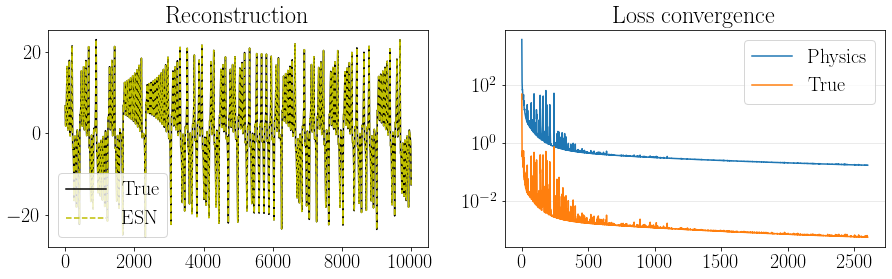

Epoch 130500, Time per epoch: 0.00415
Loss 0.17608036, True Loss: 0.00067424
Loss_change -1.540e-06, True Loss_Change: 1.087e-05
l_rate: 1.563e-03

Epoch 131000, Time per epoch: 0.00384
Loss 0.16798623, True Loss: 0.00055619
Loss_change -6.023e-06, True Loss_Change: -7.688e-06
l_rate: 1.563e-03

Epoch 131500, Time per epoch: 0.00385
Loss 0.16757824, True Loss: 0.00055375
Loss_change -6.122e-06, True Loss_Change: -8.626e-06
l_rate: 1.563e-03

Epoch 132000, Time per epoch: 0.00394
Loss 0.16744144, True Loss: 0.00055697
Loss_change -6.261e-06, True Loss_Change: -7.822e-06
l_rate: 1.563e-03

Epoch 132500, Time per epoch: 0.00374
Loss 0.16801982, True Loss: 0.00057921
Loss_change -5.019e-06, True Loss_Change: -2.933e-06
l_rate: 1.563e-03

Epoch 133000, Time per epoch: 0.00399
Loss 0.16606385, True Loss: 0.00054828
Loss_change -6.013e-06, True Loss_Change: -7.843e-06
l_rate: 1.563e-03

Epoch 133500, Time per epoch: 0.00366
Loss 0.16562100, True Loss: 0.00054640
Loss_change -6.043e-06, True L

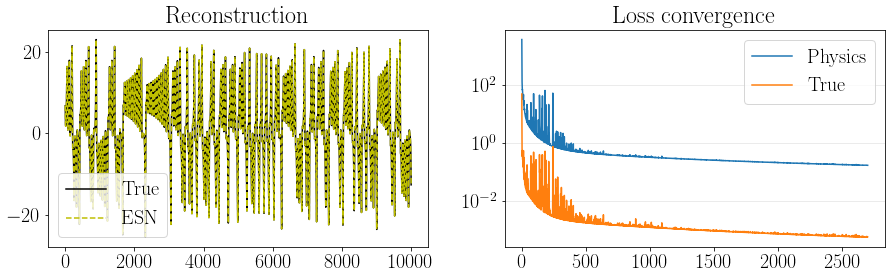

Epoch 135500, Time per epoch: 0.00400
Loss 0.16388637, True Loss: 0.00053993
Loss_change -5.803e-06, True Loss_Change: -7.110e-06
l_rate: 1.563e-03

Epoch 136000, Time per epoch: 0.00402
Loss 0.16338848, True Loss: 0.00053675
Loss_change -5.748e-06, True Loss_Change: -7.238e-06
l_rate: 1.563e-03

Epoch 136500, Time per epoch: 0.00370
Loss 0.16293480, True Loss: 0.00053637
Loss_change -5.742e-06, True Loss_Change: -6.912e-06
l_rate: 1.563e-03

Epoch 137000, Time per epoch: 0.00359
Loss 0.16248360, True Loss: 0.00053376
Loss_change -5.756e-06, True Loss_Change: -7.189e-06
l_rate: 1.563e-03

Epoch 137500, Time per epoch: 0.00363
Loss 0.16246507, True Loss: 0.00053904
Loss_change -5.664e-06, True Loss_Change: -6.692e-06
l_rate: 1.563e-03

Epoch 138000, Time per epoch: 0.00383
Loss 0.16167343, True Loss: 0.00053083
Loss_change -5.640e-06, True Loss_Change: -6.816e-06
l_rate: 1.563e-03

Epoch 138500, Time per epoch: 0.00383
Loss 0.16641234, True Loss: 0.00061258
Loss_change -2.361e-06, True 

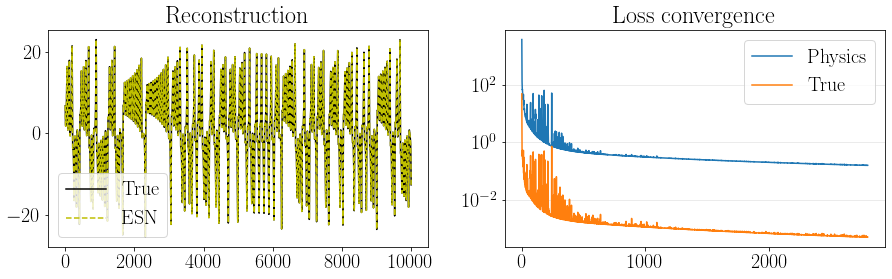

Epoch 140500, Time per epoch: 0.00417
Loss 0.15960519, True Loss: 0.00052295
Loss_change -1.032e-05, True Loss_Change: -2.893e-05
l_rate: 1.563e-03

Epoch 141000, Time per epoch: 0.00398
Loss 0.15908074, True Loss: 0.00052036
Loss_change -5.598e-06, True Loss_Change: -6.885e-06
l_rate: 1.563e-03

Epoch 141500, Time per epoch: 0.00379
Loss 0.15870163, True Loss: 0.00051902
Loss_change -5.593e-06, True Loss_Change: -6.691e-06
l_rate: 1.563e-03

Epoch 142000, Time per epoch: 0.00387
Loss 0.15822943, True Loss: 0.00051676
Loss_change -5.822e-06, True Loss_Change: -7.782e-06
l_rate: 1.563e-03

Epoch 142500, Time per epoch: 0.00382
Loss 0.15788437, True Loss: 0.00051568
Loss_change -6.420e-06, True Loss_Change: -1.232e-05
l_rate: 1.563e-03

Epoch 143000, Time per epoch: 0.00390
Loss 0.15789683, True Loss: 0.00051848
Loss_change -5.172e-06, True Loss_Change: -5.748e-06
l_rate: 1.563e-03

Epoch 143500, Time per epoch: 0.00387
Loss 0.15748119, True Loss: 0.00052115
Loss_change -5.169e-06, True 

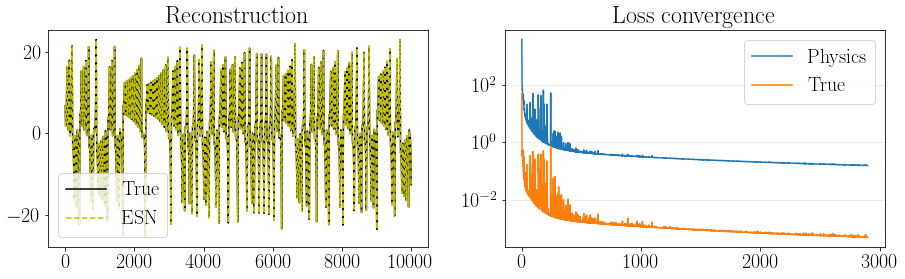

Epoch 145500, Time per epoch: 0.00435
Loss 0.15613115, True Loss: 0.00051818
Loss_change -4.967e-06, True Loss_Change: -4.197e-06
l_rate: 1.563e-03

Epoch 146000, Time per epoch: 0.00378
Loss 0.15501252, True Loss: 0.00050416
Loss_change -5.403e-06, True Loss_Change: -6.464e-06
l_rate: 1.563e-03

Epoch 146500, Time per epoch: 0.00392
Loss 0.15968929, True Loss: 0.00058574
Loss_change -2.032e-06, True Loss_Change: 8.430e-06
l_rate: 1.563e-03

Epoch 147000, Time per epoch: 0.00388
Loss 0.15440977, True Loss: 0.00050083
Loss_change -5.229e-06, True Loss_Change: -6.575e-06
l_rate: 1.563e-03

Epoch 147500, Time per epoch: 0.00399
Loss 0.15385057, True Loss: 0.00049993
Loss_change -5.599e-06, True Loss_Change: -7.824e-06
l_rate: 1.563e-03

Epoch 148000, Time per epoch: 0.00379
Loss 0.15345524, True Loss: 0.00049798
Loss_change -5.355e-06, True Loss_Change: -6.597e-06
l_rate: 1.563e-03

Epoch 148500, Time per epoch: 0.00405
Loss 0.15313272, True Loss: 0.00049706
Loss_change -8.672e-06, True L

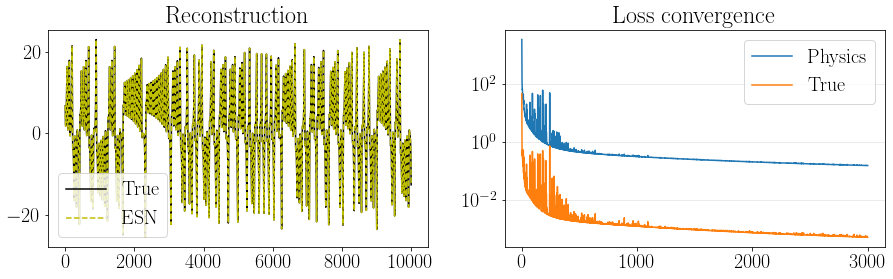

Epoch 150500, Time per epoch: 0.00401
Loss 0.15158702, True Loss: 0.00049099
Loss_change -5.289e-06, True Loss_Change: -6.509e-06
l_rate: 1.563e-03

Epoch 151000, Time per epoch: 0.00382
Loss 0.15117718, True Loss: 0.00048899
Loss_change -5.228e-06, True Loss_Change: -6.416e-06
l_rate: 1.563e-03

Epoch 151500, Time per epoch: 0.00387
Loss 0.15079845, True Loss: 0.00048771
Loss_change -5.241e-06, True Loss_Change: -6.420e-06
l_rate: 1.563e-03

Epoch 152000, Time per epoch: 0.00381
Loss 0.15041825, True Loss: 0.00048597
Loss_change -5.193e-06, True Loss_Change: -6.335e-06
l_rate: 1.563e-03

Epoch 152500, Time per epoch: 0.00377
Loss 0.15070654, True Loss: 0.00049608
Loss_change -4.763e-06, True Loss_Change: -3.951e-06
l_rate: 1.563e-03

Epoch 153000, Time per epoch: 0.00394
Loss 0.14967194, True Loss: 0.00048300
Loss_change -5.495e-06, True Loss_Change: -7.346e-06
l_rate: 1.563e-03

Epoch 153500, Time per epoch: 0.00420
Loss 0.14934328, True Loss: 0.00048232
Loss_change -5.449e-06, True 

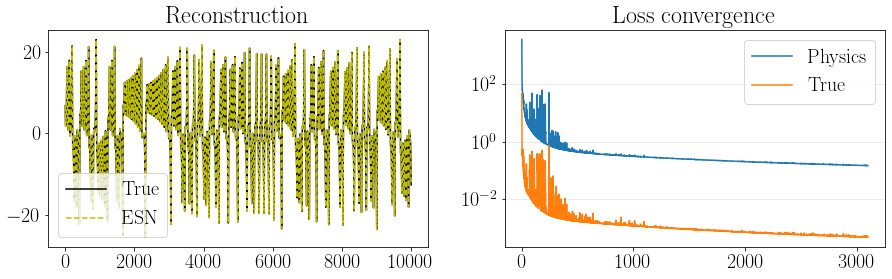

Epoch 155500, Time per epoch: 0.00453
Loss 0.14800818, True Loss: 0.00047734
Loss_change -5.488e-06, True Loss_Change: -8.555e-06
l_rate: 1.563e-03

Epoch 156000, Time per epoch: 0.00376
Loss 0.14756256, True Loss: 0.00047533
Loss_change -5.049e-06, True Loss_Change: -6.066e-06
l_rate: 1.563e-03

Epoch 156500, Time per epoch: 0.00393
Loss 0.14715844, True Loss: 0.00047326
Loss_change -8.515e-06, True Loss_Change: -2.377e-05
l_rate: 1.563e-03

Epoch 157000, Time per epoch: 0.00378
Loss 0.14717923, True Loss: 0.00047886
Loss_change -4.913e-06, True Loss_Change: -4.589e-06
l_rate: 1.563e-03

Epoch 157500, Time per epoch: 0.00399
Loss 0.14645323, True Loss: 0.00047135
Loss_change -5.051e-06, True Loss_Change: -6.062e-06
l_rate: 1.563e-03

Epoch 158000, Time per epoch: 0.00360
Loss 0.14625216, True Loss: 0.00047136
Loss_change -4.925e-06, True Loss_Change: -5.647e-06
l_rate: 1.563e-03

Epoch 158500, Time per epoch: 0.00360
Loss 0.14581938, True Loss: 0.00046872
Loss_change -5.015e-06, True 

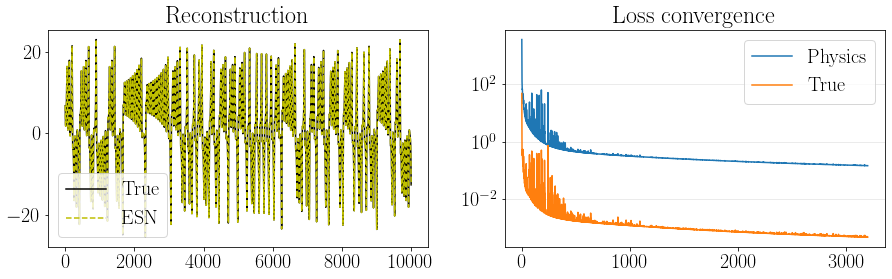

Epoch 160500, Time per epoch: 0.00420
Loss 0.14442278, True Loss: 0.00046494
Loss_change -4.961e-06, True Loss_Change: -5.602e-06
l_rate: 1.563e-03

Epoch 161000, Time per epoch: 0.00383
Loss 0.14420573, True Loss: 0.00046456
Loss_change -4.834e-06, True Loss_Change: -5.259e-06
l_rate: 1.563e-03

Epoch 161500, Time per epoch: 0.00383
Loss 0.14547679, True Loss: 0.00047753
Loss_change -3.658e-06, True Loss_Change: -2.133e-06
l_rate: 1.563e-03

Epoch 162000, Time per epoch: 0.00384
Loss 0.14341880, True Loss: 0.00046187
Loss_change -4.880e-06, True Loss_Change: -5.219e-06
l_rate: 1.563e-03

Epoch 162500, Time per epoch: 0.00368
Loss 0.14390673, True Loss: 0.00047844
Loss_change -4.725e-06, True Loss_Change: -3.686e-06
l_rate: 1.563e-03

Epoch 163000, Time per epoch: 0.00361
Loss 0.14367095, True Loss: 0.00047452
Loss_change -4.177e-06, True Loss_Change: -1.787e-06
l_rate: 1.563e-03

Epoch 163500, Time per epoch: 0.00373
Loss 0.14283636, True Loss: 0.00046189
Loss_change -4.556e-06, True 

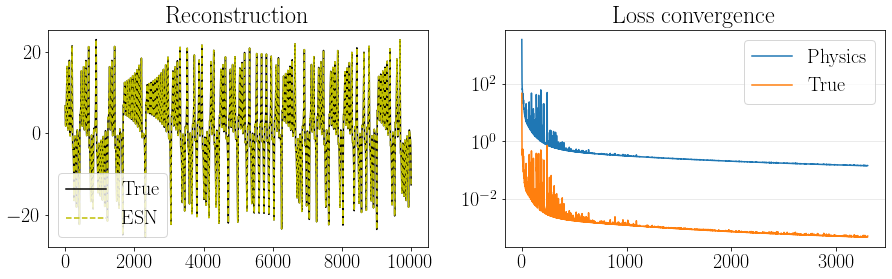

Epoch 165500, Time per epoch: 0.00429
Loss 0.14109060, True Loss: 0.00045007
Loss_change -4.903e-06, True Loss_Change: -6.059e-06
l_rate: 1.563e-03

Epoch 166000, Time per epoch: 0.00416
Loss 0.14368391, True Loss: 0.00050198
Loss_change -2.699e-06, True Loss_Change: 5.310e-06
l_rate: 1.563e-03

Epoch 166500, Time per epoch: 0.00392
Loss 0.14054573, True Loss: 0.00044757
Loss_change -4.705e-06, True Loss_Change: -5.740e-06
l_rate: 1.563e-03

Epoch 167000, Time per epoch: 0.00411
Loss 0.14013629, True Loss: 0.00044643
Loss_change -5.026e-06, True Loss_Change: -7.263e-06
l_rate: 1.563e-03

Epoch 167500, Time per epoch: 0.00369
Loss 0.14029220, True Loss: 0.00045023
Loss_change -4.392e-06, True Loss_Change: -4.692e-06
l_rate: 1.563e-03

Epoch 168000, Time per epoch: 0.00394
Loss 0.13950588, True Loss: 0.00044400
Loss_change -4.836e-06, True Loss_Change: -6.162e-06
l_rate: 1.563e-03

Epoch 168500, Time per epoch: 0.00357
Loss 0.13918562, True Loss: 0.00044263
Loss_change -4.766e-06, True L

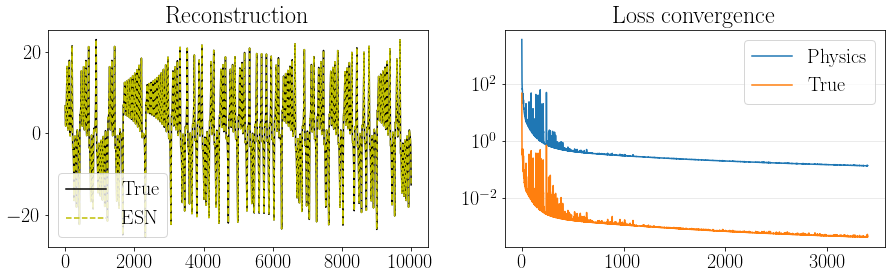

Epoch 170500, Time per epoch: 0.00400
Loss 0.13801259, True Loss: 0.00043884
Loss_change -4.645e-06, True Loss_Change: -5.948e-06
l_rate: 1.563e-03

Epoch 171000, Time per epoch: 0.00397
Loss 0.13772000, True Loss: 0.00043833
Loss_change -4.709e-06, True Loss_Change: -5.985e-06
l_rate: 1.563e-03

Epoch 171500, Time per epoch: 0.00369
Loss 0.13736342, True Loss: 0.00043603
Loss_change -5.906e-06, True Loss_Change: -9.516e-06
l_rate: 1.563e-03

Epoch 172000, Time per epoch: 0.00391
Loss 0.13704036, True Loss: 0.00043471
Loss_change -4.654e-06, True Loss_Change: -6.249e-06
l_rate: 1.563e-03

Epoch 172500, Time per epoch: 0.00374
Loss 0.13673729, True Loss: 0.00043390
Loss_change -5.243e-06, True Loss_Change: -1.027e-05
l_rate: 1.563e-03

Epoch 173000, Time per epoch: 0.00390
Loss 0.13768449, True Loss: 0.00045267
Loss_change -4.348e-06, True Loss_Change: -4.827e-06
l_rate: 1.563e-03

Epoch 173500, Time per epoch: 0.00369
Loss 0.13614208, True Loss: 0.00043155
Loss_change -4.917e-06, True 

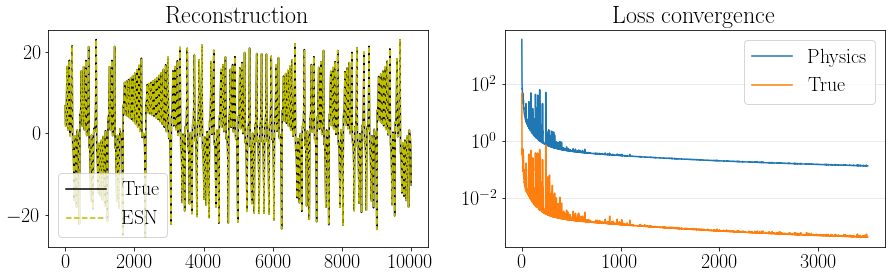

Epoch 175500, Time per epoch: 0.00422
Loss 0.13499482, True Loss: 0.00042693
Loss_change -4.516e-06, True Loss_Change: -5.419e-06
l_rate: 7.813e-04

Epoch 176000, Time per epoch: 0.00386
Loss 0.13471854, True Loss: 0.00042594
Loss_change -6.655e-06, True Loss_Change: -1.785e-05
l_rate: 7.813e-04

Epoch 176500, Time per epoch: 0.00389
Loss 0.13445543, True Loss: 0.00042557
Loss_change -4.530e-06, True Loss_Change: -5.170e-06
l_rate: 7.813e-04

Epoch 177000, Time per epoch: 0.00372
Loss 0.13414556, True Loss: 0.00042382
Loss_change -4.466e-06, True Loss_Change: -5.335e-06
l_rate: 7.813e-04

Epoch 177500, Time per epoch: 0.00390
Loss 0.13405409, True Loss: 0.00042760
Loss_change -4.653e-06, True Loss_Change: -5.293e-06
l_rate: 7.813e-04

Epoch 178000, Time per epoch: 0.00384
Loss 0.13357849, True Loss: 0.00042179
Loss_change -4.437e-06, True Loss_Change: -5.265e-06
l_rate: 7.813e-04

Epoch 178500, Time per epoch: 0.00395
Loss 0.13330416, True Loss: 0.00042156
Loss_change -4.412e-06, True 

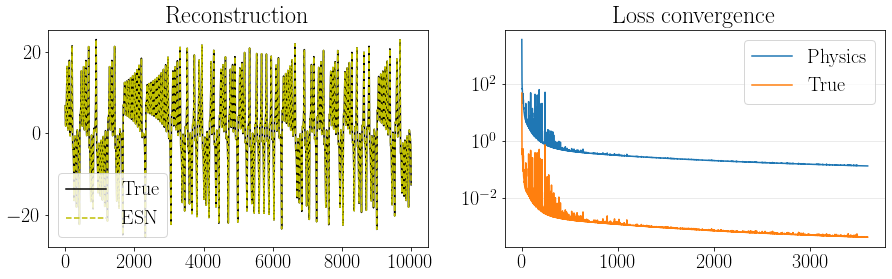

Epoch 180500, Time per epoch: 0.00426
Loss 0.13227348, True Loss: 0.00041684
Loss_change -4.339e-06, True Loss_Change: -5.278e-06
l_rate: 7.813e-04

Epoch 181000, Time per epoch: 0.00373
Loss 0.13293032, True Loss: 0.00042758
Loss_change -3.603e-06, True Loss_Change: -2.514e-06
l_rate: 7.813e-04

Epoch 181500, Time per epoch: 0.00395
Loss 0.13167626, True Loss: 0.00041681
Loss_change -4.319e-06, True Loss_Change: -4.613e-06
l_rate: 7.813e-04

Epoch 182000, Time per epoch: 0.00389
Loss 0.13216019, True Loss: 0.00042947
Loss_change -3.693e-06, True Loss_Change: -1.218e-06
l_rate: 7.813e-04

Epoch 182500, Time per epoch: 0.00398
Loss 0.13112029, True Loss: 0.00041303
Loss_change -4.284e-06, True Loss_Change: -5.052e-06
l_rate: 7.813e-04

Epoch 183000, Time per epoch: 0.00383
Loss 0.13091230, True Loss: 0.00041256
Loss_change -5.173e-06, True Loss_Change: -9.723e-06
l_rate: 7.813e-04

Epoch 183500, Time per epoch: 0.00396
Loss 0.13061672, True Loss: 0.00041122
Loss_change -4.230e-06, True 

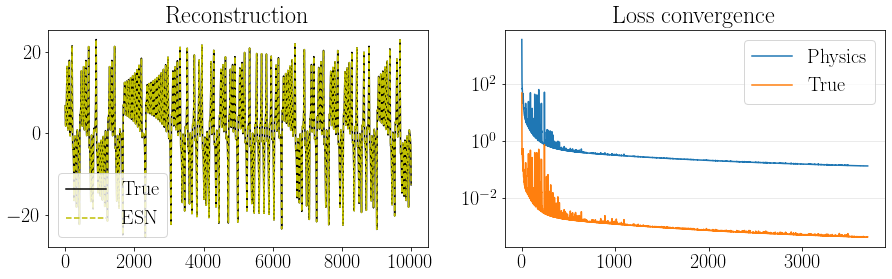

Epoch 185500, Time per epoch: 0.00434
Loss 0.12985811, True Loss: 0.00041215
Loss_change -3.956e-06, True Loss_Change: -3.587e-06
l_rate: 7.813e-04

Epoch 186000, Time per epoch: 0.00387
Loss 0.12930216, True Loss: 0.00040626
Loss_change -4.189e-06, True Loss_Change: -4.844e-06
l_rate: 7.813e-04

Epoch 186500, Time per epoch: 0.00396
Loss 0.12905523, True Loss: 0.00040570
Loss_change -4.184e-06, True Loss_Change: -4.898e-06
l_rate: 7.813e-04

Epoch 187000, Time per epoch: 0.00373
Loss 0.12876718, True Loss: 0.00040443
Loss_change -4.177e-06, True Loss_Change: -4.794e-06
l_rate: 7.813e-04

Epoch 187500, Time per epoch: 0.00399
Loss 0.12861069, True Loss: 0.00040600
Loss_change -4.232e-06, True Loss_Change: -5.320e-06
l_rate: 7.813e-04

Epoch 188000, Time per epoch: 0.00388
Loss 0.12825352, True Loss: 0.00040267
Loss_change -4.152e-06, True Loss_Change: -4.749e-06
l_rate: 7.813e-04

Epoch 188500, Time per epoch: 0.00398
Loss 0.12809871, True Loss: 0.00040442
Loss_change -4.064e-06, True 

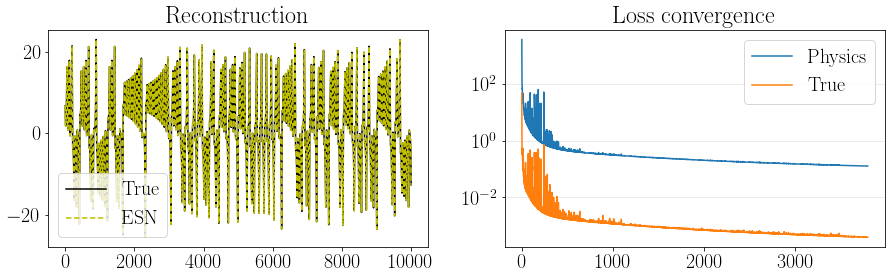

Epoch 190500, Time per epoch: 0.00421
Loss 0.12696931, True Loss: 0.00039805
Loss_change -4.178e-06, True Loss_Change: -4.719e-06
l_rate: 7.813e-04

Epoch 191000, Time per epoch: 0.00388
Loss 0.12673736, True Loss: 0.00039812
Loss_change -4.886e-06, True Loss_Change: -7.399e-06
l_rate: 7.813e-04

Epoch 191500, Time per epoch: 0.00374
Loss 0.12704800, True Loss: 0.00040577
Loss_change -3.643e-06, True Loss_Change: -2.720e-06
l_rate: 7.813e-04

Epoch 192000, Time per epoch: 0.00400
Loss 0.12628251, True Loss: 0.00039590
Loss_change -4.654e-06, True Loss_Change: -8.480e-06
l_rate: 7.813e-04

Epoch 192500, Time per epoch: 0.00397
Loss 0.12604755, True Loss: 0.00039583
Loss_change -4.024e-06, True Loss_Change: -4.345e-06
l_rate: 7.813e-04

Epoch 193000, Time per epoch: 0.00395
Loss 0.12580149, True Loss: 0.00039413
Loss_change -4.063e-06, True Loss_Change: -4.678e-06
l_rate: 7.813e-04

Epoch 193500, Time per epoch: 0.00384
Loss 0.12665600, True Loss: 0.00040633
Loss_change -3.127e-06, True 

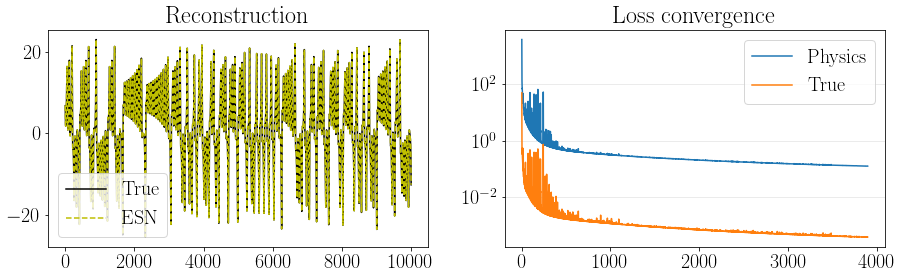

Epoch 195500, Time per epoch: 0.00408
Loss 0.12554470, True Loss: 0.00040470
Loss_change -3.436e-06, True Loss_Change: -1.842e-06
l_rate: 7.813e-04

Epoch 196000, Time per epoch: 0.00397
Loss 0.12428075, True Loss: 0.00038836
Loss_change -4.040e-06, True Loss_Change: -4.609e-06
l_rate: 7.813e-04

Epoch 196500, Time per epoch: 0.00362
Loss 0.12430726, True Loss: 0.00039179
Loss_change -3.820e-06, True Loss_Change: -3.549e-06
l_rate: 7.813e-04

Epoch 197000, Time per epoch: 0.00383
Loss 0.12380458, True Loss: 0.00038681
Loss_change -4.008e-06, True Loss_Change: -4.555e-06
l_rate: 7.813e-04

Epoch 197500, Time per epoch: 0.00394
Loss 0.12359713, True Loss: 0.00038714
Loss_change -4.056e-06, True Loss_Change: -4.869e-06
l_rate: 7.813e-04

Epoch 198000, Time per epoch: 0.00395
Loss 0.12358604, True Loss: 0.00038832
Loss_change -3.777e-06, True Loss_Change: -3.696e-06
l_rate: 7.813e-04

Epoch 198500, Time per epoch: 0.00381
Loss 0.12323596, True Loss: 0.00038722
Loss_change -3.946e-06, True 

In [11]:
learn         = 0.1 #initial learning rate
optimizer     = tf.keras.optimizers.Adam(learning_rate=learn) #Adam optimizer

Loss_Mse      = tf.keras.losses.MeanSquaredError() # MSE

num_epochs    = 200000 #number of epochs

n_learn       = 10000 #check loss n_learn epochs before to update learning rate    
true_losses   = np.zeros(num_epochs+n_learn+1) #arrays to save the losses
losses        = np.zeros(num_epochs+n_learn+1)
losses[0:n_learn]    = 1e6 #needed to avoid changes the learning rate at the beginning of the optimization

def train():
    
    global learn
        
    l                    = 8 #number of batches
    r1, dr1, y_o1, dy_o1 = batchez(l,r, dr, y_o, dy_o) #creates the batches

    mid_time             = time.time() #intialize time (to check how long it takes)
    n_save               = 50  #save loss every n_save points
    n_print              = 500  #print every n_print epochs
    n_plot               = 5000 #plot every n_plot epochs 
    
    
    for epoch in range(num_epochs):
        
        for ij in range(l):
        #each epoch we iterate through all the batches
            loss, yder, ylor = phys_loss(r1[ij],dr1[ij],y_o1[ij],dy_o1[ij])

        #Save loss and check learning rate (larger n_save are recommended to speed up computations)
        if (epoch % n_save) == 0:
                    
            Wouth = Wout_hid.numpy()
            
            # true loss of the reconstruction (computed with respect to data for the hidden states)
            if FE:
                true_loss = Loss_Mse(u_t[begin:end,idx1[n_observed:]],
                           np.matmul(r[0,-(end-begin):],Wouth[:,-1:])).numpy()
            else:
                true_loss = Loss_Mse(u_t[1+begin:1+end,idx1[n_observed:]],
                           np.matmul(r[0,-(end-begin):],Wouth[:,-1:])).numpy()
                
            true_losses[epoch+n_learn]  = true_loss #save true loss
            losses[epoch+n_learn]       = loss.numpy() #save physics loss
            
            #mean relative decrease of the loss in the previous n_learn epochs
            Improvement  = (losses[epoch+n_learn] - losses[epoch]) \
                                 /losses[epoch+n_learn]/n_learn
            True_Improvement = (true_losses[epoch+n_learn] - true_losses[epoch]) \
                                 /true_losses[epoch+n_learn]/n_learn
            
            if Improvement>0:  #if the loss increased in the last n_learn epochs halves the learning rate
                learn    = 0.5*learn
                optimizer.learning_rate=learn

        #Print intermediate results
        if (epoch % n_print) == 0:
            print("Epoch {:05d}, Time per epoch: {:.5f}".format(epoch,
                                                                (time.time() - mid_time)/n_print))
            print("Loss {:.8f}, True Loss: {:.8f}".format(loss.numpy(), true_loss))
            #first n_learn steps are meaningless for the change
            print("Loss_change {:.3e}, True Loss_Change: {:.3e}".format(Improvement,
                                                                        True_Improvement))
            print("l_rate: {:.3e}".format(learn))
            print('')
            mid_time = time.time()

        
        # Plot current state of the reconstruction and loss convergence    
        if (epoch % n_plot) == 0:
            plt.subplot(1,2,1)
            plt.title('Reconstruction')
            plt.plot(u_t[1+begin:1+end,idx1[n_observed:]], 'k', label='True')
            plt.plot(np.matmul(stored_outputs[begin:end],Wouth),'y--', label='ESN')
            plt.legend()
            plt.subplot(1,2,2)
            plt.title('Loss convergence')
            plt.yscale('log')
            plt.grid(True, which="both", axis='y', ls="-", alpha=0.3)
            plt.plot(losses[np.nonzero(losses)][n_learn:], label='Physics')
            plt.plot(true_losses[np.nonzero(losses)][n_learn:], label='True')
            plt.legend()
            plt.show()

                
init_time = time.time()
train()
print('Average time per iteration:', (time.time() - init_time)/num_epochs )

In [12]:
# save final output matrix for the hidden state and loss history
if FE:
    fln = './data/Lorenz_Rec_x_' + str(idx) + '_' + str(num_units) + '_' + str(end) + '_FE.h5'
else:
    fln = './data/Lorenz_Rec_x_' + str(idx) + '_' + str(num_units) + '_' + str(end) + '.h5'

losses[0:n_learn]    = 0  #remove the first transient where loss was imposed equal to 1e6

hf = h5py.File(fln,'w')
hf.create_dataset('Wout'     ,data=Wout_hid.numpy())
hf.create_dataset('loss'     ,data=losses[np.nonzero(losses)])
hf.create_dataset('true_loss',data=true_losses[np.nonzero(losses)])
hf.close()